The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
Simulated GD1
beginning least square optimization


/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/chainconsumer/chain.py:313: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = rng.multivariate_normal(mean, covariance, size=1000000)  # type: ignore
/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/chainconsumer/chain.py:313: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = rng.multivariate_normal(mean, covariance, size=1000000)  # type: ignore
/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/chainconsumer/chain.py:313: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = rng.multivariate_normal(mean, covariance, size=1000000)  # type: ignore


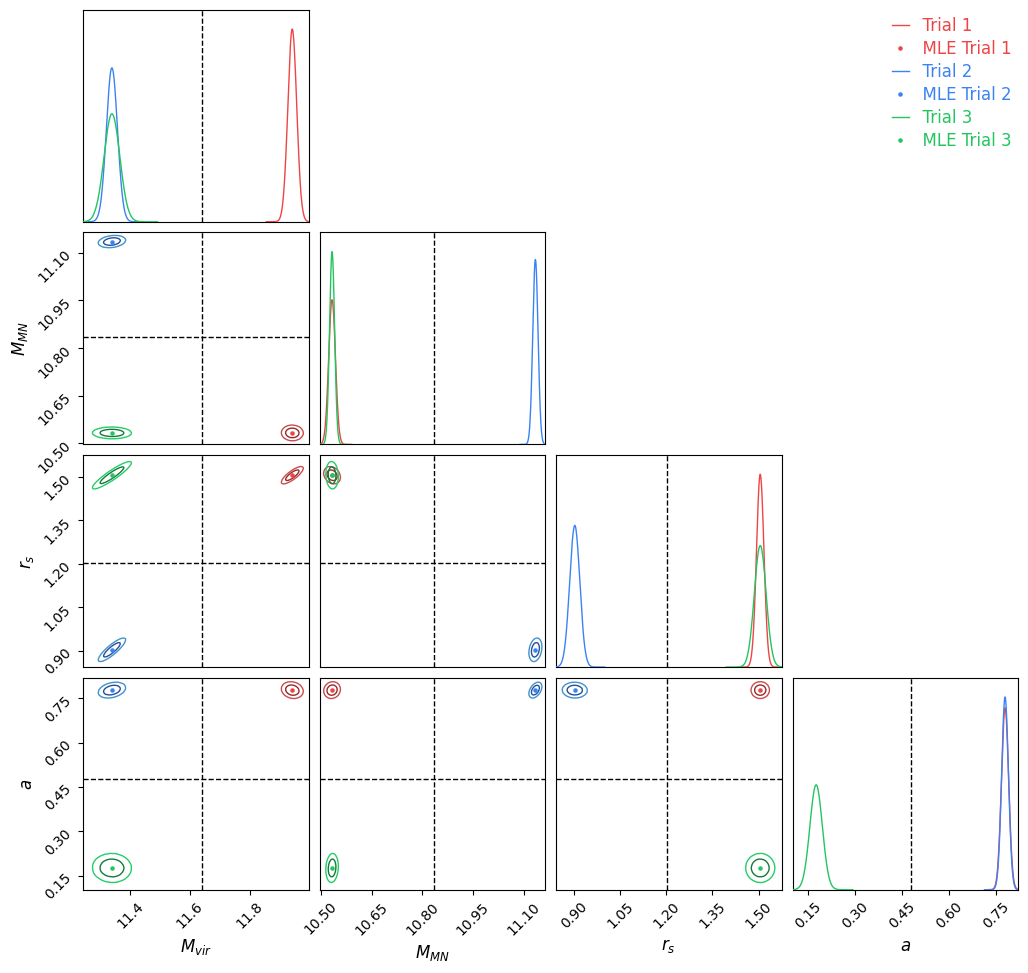

In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '2' 
from autocvd import autocvd
autocvd(num_gpus = 1)

import jax 
import jax.numpy as jnp
from jax import jit, random
import equinox as eqx
from jax.sharding import Mesh, PartitionSpec, NamedSharding

# jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt

from functools import partial

import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_LAXMAP, DIRECT_ACC_FOR_LOOP, DIRECT_ACC_MATRIX, NO_SELF_GRAVITY
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL, DIFFRAX_BACKEND, LEAPFROG
from odisseo.option_classes import SEMIIMPLICITEULER, TSIT5
from odisseo.option_classes import RECURSIVECHECKPOINTADJOING, FORWARDMODE
from odisseo.initial_condition import Plummer_sphere, Plummer_sphere_reparam
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot
from odisseo.potentials import MyamotoNagai, NFW

from odisseo.utils import halo_to_gd1_velocity_vmap, halo_to_gd1_vmap, projection_on_GD1
from jax.test_util import check_grads
from interpax import Interpolator1D


plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

plt.style.use('default')


code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1, unit_time = code_time )  


config = SimulationConfig(N_particles = 1000, 
                          return_snapshots = True, 
                          num_snapshots = 1000, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.pc).to(code_units.code_length).value,
                          integrator = DIFFRAX_BACKEND,
                          differentation_mode=TSIT5,
                          fixed_timestep=False,
                          ) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.5 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 


key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)

#the center of mass needs to be integrated backwards in time first 
config_com = config._replace(N_particles=1,)
params_com = params._replace(t_end=-params.t_end,)

#this is the final position of the cluster, we need to integrate backwards in time 
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)


mass_com = jnp.array([params_com.Plummer_params.Mtot])
final_state_com = construct_initial_state(pos_com_final, vel_com_final)

snapshots_com = time_integration(final_state_com, mass_com, config_com, params_com)
pos_com, vel_com = snapshots_com.states[-1, :, 0], snapshots_com.states[-1, :, 1]


# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities)

#run the simulation
snapshots = time_integration(initial_state_stream, mass, config, params)

final_state = snapshots.states[-1]
stream_data = projection_on_GD1(final_state, code_units=code_units,)
print("Simulated GD1")


# LET'S TRY OPTIMIZING IT

params_sim = params
config_com = config_com._replace(diffrax_adjoint_method=FORWARDMODE,
)

@partial(jit, static_argnames=['return_residual'])
def run_simulation( y, return_residual=True):

    Mvir, M_MN, r_s, a = y
    Mvir = 10**Mvir
    M_MN = 10**M_MN
    r_s = 10**r_s
    a = 10**a

    phi1_min, phi1_max = -100, 25
    phi2_min, phi2_max = -8, 2

    coord_indices = jnp.array([2, 3, 4, 5])


    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)

    #function that integrates the com backwards and forwards in time and then the stream, and projects it on the sky
    @jit
    def assign_params_integrate_projection(t_end):
        

        new_params = params_sim._replace(
                    NFW_params=params_sim.NFW_params._replace(
                        Mvir=Mvir * u.Msun.to(code_units.code_mass), 
                        r_s=r_s * u.kpc.to(code_units.code_length)
                    ),
                    MN_params=params_sim.MN_params._replace(
                        M=M_MN * u.Msun.to(code_units.code_mass),
                        a=a * u.kpc.to(code_units.code_length)
                    ),
                     t_end = t_end,)
        snapshots = time_integration(initial_state_com, mass, config=config_com, params=new_params)
        stream_coordinate = jax.vmap(projection_on_GD1, in_axes=(0, None))(snapshots.states, code_units)
        return stream_coordinate

    t_end_mag = 0.2 * u.Gyr.to(code_units.code_time)
    t_end_array = jnp.array([-t_end_mag, t_end_mag])  # backward, forward
    

    # vmap over both parameters
    stream_coordinate_com = jax.vmap(assign_params_integrate_projection)(t_end_array)
    stream_coordinate_com_backward, stream_coordinate_com_forward = stream_coordinate_com[0], stream_coordinate_com[1]


    # Create masks for valid time steps
    mask_window_backward = (stream_coordinate_com_backward[:, 0, 1] < phi1_max) & \
                          (stream_coordinate_com_backward[:, 0, 1] > phi1_min) & \
                          (stream_coordinate_com_backward[:, 0, 2] < phi2_max) & \
                          (stream_coordinate_com_backward[:, 0, 2] > phi2_min)
    
    mask_diff_backward = jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1) > 0
    # New mask - True until first False appears
    mask_diff_backward = jnp.cumprod(mask_diff_backward, dtype=bool)


    mask_window_forward = (stream_coordinate_com_forward[:, 0, 1] < phi1_max) & \
                         (stream_coordinate_com_forward[:, 0, 1] > phi1_min) & \
                         (stream_coordinate_com_forward[:, 0, 2] < phi2_max) & \
                         (stream_coordinate_com_forward[:, 0, 2] > phi2_min)
    
    mask_diff_forward = jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=-1) < 0
    mask_diff_forward = jnp.cumprod(mask_diff_forward, dtype=bool)


    # Combined time step masks
    valid_time_backward = mask_window_backward & mask_diff_backward
    valid_time_forward = mask_window_forward & mask_diff_forward

    
    def forward_fill(arr, mask):
        """Forward-fill masked array: replace invalid entries with the last valid value."""
        mask_f = mask.astype(arr.dtype)
        arr_masked = jnp.where(mask, arr, 0.0)
        count = jnp.cumsum(mask_f)
        cumsum_vals = jnp.cumsum(arr_masked * mask_f)
        filled = jnp.where(count > 0, cumsum_vals / count, arr_masked)
        return filled

    def backward_fill(arr, mask):
        """Backward-fill masked array: replace invalid entries with the next valid value."""
        return forward_fill(arr[::-1], mask[::-1])[::-1]

    def smart_fill_by_phi(arr, mask, phi):
        """
        Choose fill direction based on monotonicity of `phi` along index:
        - if phi[-1] - phi[0] >= 0  -> use forward_fill (phi increasing)
        - else                     -> use backward_fill (phi decreasing)
        This is JAX-safe (uses lax.cond on a traced boolean).
        """
        # delta is a scalar (traced possible)
        delta = phi[1] - phi[0]

        # Use lax.cond to pick the branch in a JAX-traceable way
        return jax.lax.cond(delta >= 0.0,
                        lambda _: backward_fill(arr, mask),
                        lambda _: forward_fill(arr, mask),
                        operand=None)
    
    # Backward interpolation (inside run_simulation)

    phi1_backward_valid = smart_fill_by_phi(stream_coordinate_com_backward[:, 0, 1], valid_time_backward, stream_coordinate_com_backward[:, 0, 1])
    phi1_forward_valid = smart_fill_by_phi(stream_coordinate_com_forward[:, 0, 1], valid_time_forward, stream_coordinate_com_forward[:, 0, 1])

    # Create masked coordinates for interpolation (only valid time steps)
    # phi1_backward_valid = jnp.where(valid_time_backward, 
    #                                stream_coordinate_com_backward[:, 0, 1], 
    #                                10000.)
    
    
    # phi1_forward_valid = jnp.where(valid_time_forward, 
    #                               stream_coordinate_com_forward[:, 0, 1], 
    #                               -10000.)
    

    # Stream data masks - which data points to use for each direction
    mask_stream_backward = stream_data[:, 1] > stream_coordinate_com_backward[0, 0, 1]
    mask_stream_forward = stream_data[:, 1] < stream_coordinate_com_forward[0, 0, 1]

    mask_evaluate_inside_track_backward = (stream_data[:, 1] < jnp.max(phi1_backward_valid)) & (stream_data[:, 1] < phi1_max)
    mask_evaluate_inside_track_forward = (stream_data[:, 1] > jnp.min(phi1_forward_valid)) & (stream_data[:, 1] > phi1_min)

    # def interpolate_coord_backward(coord_idx):

    #     coord_backward_valid = jnp.where(valid_time_backward, 
    #                                stream_coordinate_com_backward[:, 0, coord_idx], 
    #                                -100000.0)

    #     return jnp.interp(
    #         jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward, stream_data[:, 1], 100000.0), 
    #         phi1_backward_valid, 
    #         coord_backward_valid
    #     )
    
    # def interpolate_coord_forward(coord_idx):

    #     coord_forward_valid = jnp.where(valid_time_forward, 
    #                                stream_coordinate_com_forward[:, 0, coord_idx], 
    #                                100000.0)

    #     return jnp.interp(
    #         -jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward, stream_data[:, 1], -100000.0), 
    #         -phi1_forward_valid, 
    #         coord_forward_valid
    #     )
    
    # --- Interpolate using phi1_*_valid as x-knots, and fill y outside mask with last valid coordinate ---
    def interpolate_coord_backward(coord_idx):
        """
        Use phi1_backward_valid as x_knots (full-length).
        Fill the coordinate values outside the valid mask using smart_fill_by_phi,
        then build Interpolator1D with extrap set to boundary y values.
        """
        # x knots: filled phi1 array (static length = n_snapshots)
        x_knots = phi1_backward_valid  # shape (n_snapshots,)
        # raw y along snapshots
        y_all = stream_coordinate_com_backward[:, 0, coord_idx]  # shape (n_snapshots,)
        # fill y outside mask according to phi monotonicity (keeps static shape)
        y_knots = smart_fill_by_phi(y_all, valid_time_backward, stream_coordinate_com_backward[:, 0, 1])

        # number of valid knots (used only in conds)
        n_valid = jnp.sum(valid_time_backward).astype(jnp.int32)

        # query points (evaluate everywhere; residual mask later selects used ones)
        x_query = stream_data[:, 1]

        # branch on n_valid to handle 0/1/>=2 edge cases safely
        def no_knots():
            return jnp.zeros_like(x_query)

        def one_knot():
            first_idx = jnp.argmax(valid_time_backward)  # index of the single valid
            val = y_knots[first_idx]
            return jnp.full_like(x_query, val)

        def many_knots():
            # left/right fill from filled y_knots boundary values (time-ordered)
            left_fill = y_knots[0]
            right_fill = y_knots[-1]
            interp = Interpolator1D(x_knots, y_knots, extrap=(left_fill, right_fill))
            return interp(x_query)

        return jax.lax.cond(n_valid == 0,
                            no_knots,
                            lambda: jax.lax.cond(n_valid == 1, one_knot, many_knots))


    def interpolate_coord_forward(coord_idx):
        """
        Use phi1_forward_valid as x_knots (full-length).
        Fill the coordinate values outside the valid mask using smart_fill_by_phi,
        then build Interpolator1D with extrap set to boundary y values.
        """
        x_knots = phi1_forward_valid
        y_all = stream_coordinate_com_forward[:, 0, coord_idx]
        y_knots = smart_fill_by_phi(y_all, valid_time_forward, stream_coordinate_com_forward[:, 0, 1])

        n_valid = jnp.sum(valid_time_forward).astype(jnp.int32)
        x_query = stream_data[:, 1]

        def no_knots():
            return jnp.zeros_like(x_query)

        def one_knot():
            first_idx = jnp.argmax(valid_time_forward)
            val = y_knots[first_idx]
            return jnp.full_like(x_query, val)

        def many_knots():
            left_fill = y_knots[0]
            right_fill = y_knots[-1]
            interp = Interpolator1D(x_knots, y_knots, extrap=(left_fill, right_fill))
            return interp(x_query)

        return jax.lax.cond(n_valid == 0,
                            no_knots,
                            lambda: jax.lax.cond(n_valid == 1, one_knot, many_knots))

        

    # Apply interpolation to all coordinates
    interp_tracks_backward = jax.vmap(interpolate_coord_backward)(coord_indices)  # Shape: (n_coords, n_data)
    interp_tracks_forward = jax.vmap(interpolate_coord_forward)(coord_indices)  # Shape: (n_coords, n_data)

    # Calculate residuals for all coordinates
    data_coords = stream_data[:, coord_indices].T  # Shape: (n_coords, n_data)
    sigma = jnp.array([0.5, 10., 2., 2. ])

    
    mask_correct_interpolation_backward = phi1_backward_valid < 20
    mask_correct_interpolation_forward = phi1_forward_valid > - 95

    # Calculate chi2 using only the appropriate data points for each direction
    residuals_backward = jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward, 
                                  (data_coords - interp_tracks_backward)/sigma[:, None],
                                  0.0)
    residuals_forward = jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward, 
                                 (data_coords - interp_tracks_forward)/sigma[:, None],
                                 0.0)
    
    chi2_backward = jnp.sum(residuals_backward**2) 
    chi2_forward = jnp.sum(residuals_forward**2) 
    
    # Use only backward for now (as in your original code)
    chi2 = chi2_backward + chi2_forward

    if return_residual:
        return jnp.concatenate([residuals_backward**2, residuals_forward**2], axis=0).flatten()
    else:
        return chi2
    

print("beginning least square optimization")

from optimistix import least_squares
import optimistix


# Shape will be (4, 4)

y0_batched = jnp.array([
    # Original array
    [jnp.log10(params.NFW_params.Mvir * 2 * code_units.code_mass.to(u.Msun)), 
     jnp.log10(params.MN_params.M * 0.5 * code_units.code_mass.to(u.Msun)),
     jnp.log10(params.NFW_params.r_s * 2 * code_units.code_length.to(u.kpc)),
     jnp.log10(params.MN_params.a * 2 * code_units.code_length.to(u.kpc))],
    
    # Variation 1: swap some factors
    [jnp.log10(params.NFW_params.Mvir * 0.5 * code_units.code_mass.to(u.Msun)), 
     jnp.log10(params.MN_params.M * 2 * code_units.code_mass.to(u.Msun)),
     jnp.log10(params.NFW_params.r_s * 0.5 * code_units.code_length.to(u.kpc)),
     jnp.log10(params.MN_params.a * 2 * code_units.code_length.to(u.kpc))],
    
    # Variation 2: different swaps
    # [jnp.log10(params.NFW_params.Mvir * 0.5 * code_units.code_mass.to(u.Msun)), 
    #  jnp.log10(params.MN_params.M * 0.5 * code_units.code_mass.to(u.Msun)),
    #  jnp.log10(params.NFW_params.r_s * 0.5 * code_units.code_length.to(u.kpc)),
    #  jnp.log10(params.MN_params.a * 0.5 * code_units.code_length.to(u.kpc))],
    
    # Variation 3: more swaps
    [jnp.log10(params.NFW_params.Mvir * 0.5 * code_units.code_mass.to(u.Msun)), 
     jnp.log10(params.MN_params.M * 0.5 * code_units.code_mass.to(u.Msun)),
     jnp.log10(params.NFW_params.r_s * 2 * code_units.code_length.to(u.kpc)),
     jnp.log10(params.MN_params.a * 0.5 * code_units.code_length.to(u.kpc))],
])

# Shape will be (4, 4)
def minimization_vmap(y0):
    return least_squares(
        fn=run_simulation,
        solver=optimistix.LevenbergMarquardt(rtol=1e-5, atol=1e-5),
        y0=y0,
    ).value

values = jax.vmap(minimization_vmap)(y0_batched)


#remember to put FORWARD MODE for the adjoint method when calculating the hessian
config_com = config_com._replace(diffrax_adjoint_method=FORWARDMODE,)
hessians = jax.vmap(lambda v: jax.jacfwd(jax.jacfwd(run_simulation))(v, False))(values)


fisher_info =  hessians
covariance = 2.0 * jax.vmap(jnp.linalg.inv)(fisher_info)

from chainconsumer import Chain, ChainConsumer, Truth

colors = ['red', 'blue', 'green', 'purple']
c = ChainConsumer()
for i in range(values.shape[0]):
    chain = Chain.from_covariance(mean=values[i], covariance=covariance[i], columns=["$M_{vir}$", "$M_{MN}$", "$r_s$", "$a$"], color=colors[i], name=f'Trial {i+1}')
    c.add_chain(chain)
    c.add_marker(location = {"$M_{vir}$": np.array(values[i][0]), "$M_{MN}$": np.array(values[i][1]),
                             "$r_s$": np.array(values[i][2]), "$a$": np.array(values[i][3])}, name=f"MLE Trial {i+1}",  color=colors[i], marker='x')

c.add_truth(Truth(location = {"$M_{vir}$": jnp.log10(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun)), 
                              "$M_{MN}$": jnp.log10(params.MN_params.M * code_units.code_mass.to(u.Msun)),
                              "$r_s$": jnp.log10(params.NFW_params.r_s * code_units.code_length.to(u.kpc)),
                              "$a$": jnp.log10(params.MN_params.a * code_units.code_length.to(u.kpc))}, color='black', name="True value"))

fig = c.plotter.plot()
# fig.savefig("Fisher_contour_least_square_vmap.png", dpi=300)

In [2]:
values

Array([[11.941345  , 10.532715  ,  1.50515   ,  0.7781512 ],
       [11.339285  , 11.134775  ,  0.90308994,  0.7781512 ],
       [11.339285  , 10.532715  ,  1.50515   ,  0.17609125]],      dtype=float32)

In [5]:
colors = ['red', 'blue', 'green', 'purple']
c = ChainConsumer()
fig = plt.figure()
for i in range(values.shape[0]):
    chain = Chain.from_covariance(mean=values[2], covariance=covariance[2], columns=["$M_{vir}$", "$M_{MN}$", "$r_s$", "$a$"], color=colors[i], name=f'Trial {i+1}')
    c.add_chain(chain)
    c.add_marker(location = {"$M_{vir}$": np.array(values[i][0]), "$M_{MN}$": np.array(values[i][1]),
                             "$r_s$": np.array(values[i][2]), "$a$": np.array(values[i][3])}, name=f"MLE Trial {i+1}",  color=colors[i], marker='x')

c.add_truth(Truth(location = {"$M_{vir}$": jnp.log10(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun)), 
                              "$M_{MN}$": jnp.log10(params.MN_params.M * code_units.code_mass.to(u.Msun)),
                              "$r_s$": jnp.log10(params.NFW_params.r_s * code_units.code_length.to(u.kpc)),
                              "$a$": jnp.log10(params.MN_params.a * code_units.code_length.to(u.kpc))}, color='black', name="True value"))

fig = c.plotter.plot()

LinAlgError: SVD did not converge

<Figure size 640x480 with 0 Axes>

Simulated GD1
beginning least square optimization


/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/chainconsumer/chain.py:313: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = rng.multivariate_normal(mean, covariance, size=1000000)  # type: ignore
/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/chainconsumer/chain.py:313: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = rng.multivariate_normal(mean, covariance, size=1000000)  # type: ignore
/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/chainconsumer/chain.py:313: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = rng.multivariate_normal(mean, covariance, size=1000000)  # type: ignore


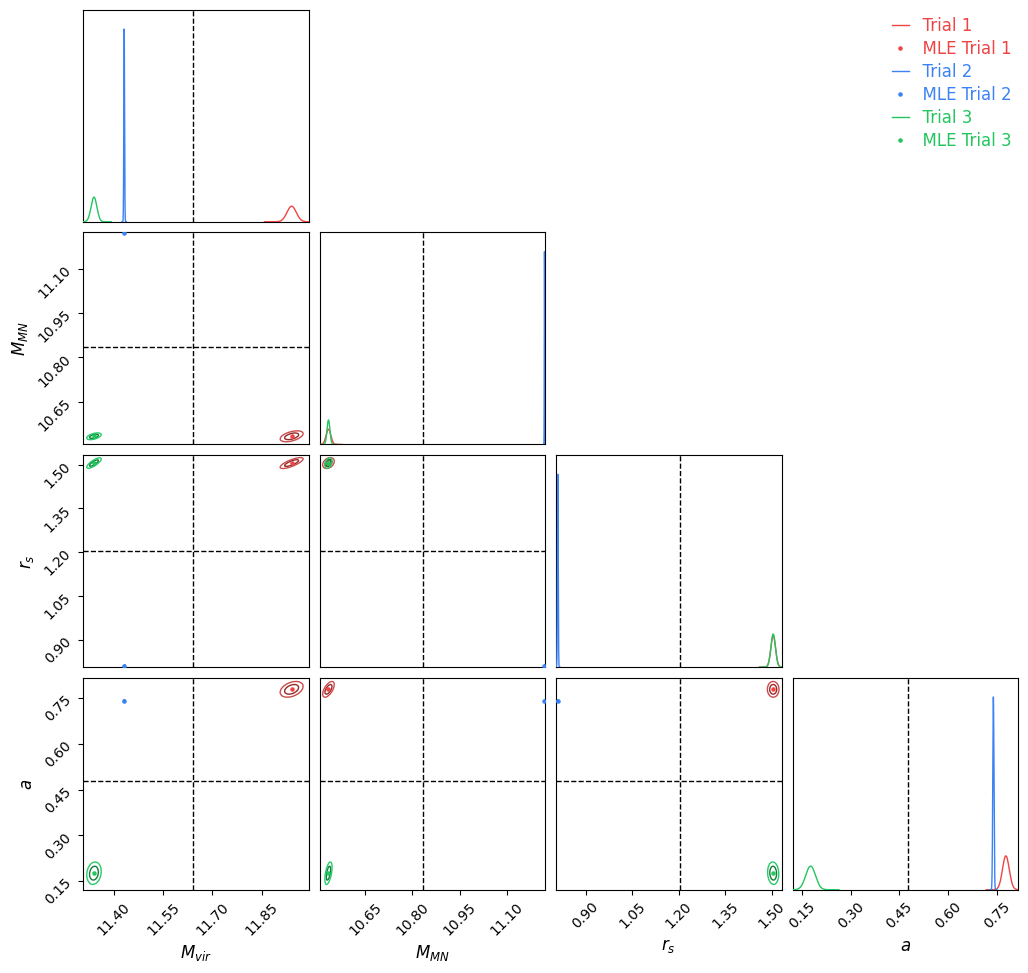

In [2]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '2' 
from autocvd import autocvd
autocvd(num_gpus = 1)

import jax 
import jax.numpy as jnp
from jax import jit, random
import equinox as eqx
from jax.sharding import Mesh, PartitionSpec, NamedSharding

# jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt

from functools import partial

import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_LAXMAP, DIRECT_ACC_FOR_LOOP, DIRECT_ACC_MATRIX, NO_SELF_GRAVITY
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL, DIFFRAX_BACKEND, LEAPFROG
from odisseo.option_classes import SEMIIMPLICITEULER, TSIT5
from odisseo.option_classes import RECURSIVECHECKPOINTADJOING, FORWARDMODE
from odisseo.initial_condition import Plummer_sphere, Plummer_sphere_reparam
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot
from odisseo.potentials import MyamotoNagai, NFW

from odisseo.utils import halo_to_gd1_velocity_vmap, halo_to_gd1_vmap, projection_on_GD1
from jax.test_util import check_grads
from interpax import Interpolator1D


plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

plt.style.use('default')


code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1, unit_time = code_time )  


config = SimulationConfig(N_particles = 1000, 
                          return_snapshots = True, 
                          num_snapshots = 1000, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.pc).to(code_units.code_length).value,
                          integrator = DIFFRAX_BACKEND,
                          differentation_mode=TSIT5,
                          fixed_timestep=False,
                          ) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.5 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 


key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)

#the center of mass needs to be integrated backwards in time first 
config_com = config._replace(N_particles=1,)
params_com = params._replace(t_end=-params.t_end,)

#this is the final position of the cluster, we need to integrate backwards in time 
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)


mass_com = jnp.array([params_com.Plummer_params.Mtot])
final_state_com = construct_initial_state(pos_com_final, vel_com_final)

snapshots_com = time_integration(final_state_com, mass_com, config_com, params_com)
pos_com, vel_com = snapshots_com.states[-1, :, 0], snapshots_com.states[-1, :, 1]


# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities)

#run the simulation
snapshots = time_integration(initial_state_stream, mass, config, params)

final_state = snapshots.states[-1]
stream_data = projection_on_GD1(final_state, code_units=code_units,)
print("Simulated GD1")


# LET'S TRY OPTIMIZING IT

params_sim = params
config_com = config_com._replace(diffrax_adjoint_method=FORWARDMODE,
)

@partial(jit, static_argnames=['return_residual'])
def run_simulation( y, return_residual=True):

    Mvir, M_MN, r_s, a = y
    Mvir = 10**Mvir
    M_MN = 10**M_MN
    r_s = 10**r_s
    a = 10**a

    phi1_min, phi1_max = -100, 25
    phi2_min, phi2_max = -8, 2

    coord_indices = jnp.array([2, 3, 4, 5])


    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)

    #function that integrates the com backwards and forwards in time and then the stream, and projects it on the sky
    @jit
    def assign_params_integrate_projection(t_end):
        

        new_params = params_sim._replace(
                    NFW_params=params_sim.NFW_params._replace(
                        Mvir=Mvir * u.Msun.to(code_units.code_mass), 
                        r_s=r_s * u.kpc.to(code_units.code_length)
                    ),
                    MN_params=params_sim.MN_params._replace(
                        M=M_MN * u.Msun.to(code_units.code_mass),
                        a=a * u.kpc.to(code_units.code_length)
                    ),
                     t_end = t_end,)
        snapshots = time_integration(initial_state_com, mass, config=config_com, params=new_params)
        stream_coordinate = jax.vmap(projection_on_GD1, in_axes=(0, None))(snapshots.states, code_units)
        return stream_coordinate

    t_end_mag = 0.2 * u.Gyr.to(code_units.code_time)
    t_end_array = jnp.array([-t_end_mag, t_end_mag])  # backward, forward
    

    # vmap over both parameters
    stream_coordinate_com = jax.vmap(assign_params_integrate_projection)(t_end_array)
    stream_coordinate_com_backward, stream_coordinate_com_forward = stream_coordinate_com[0], stream_coordinate_com[1]


    # Create masks for valid time steps
    mask_window_backward = (stream_coordinate_com_backward[:, 0, 1] < phi1_max) & \
                          (stream_coordinate_com_backward[:, 0, 1] > phi1_min) & \
                          (stream_coordinate_com_backward[:, 0, 2] < phi2_max) & \
                          (stream_coordinate_com_backward[:, 0, 2] > phi2_min)
    
    mask_diff_backward = jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1) > 0
    # New mask - True until first False appears
    mask_diff_backward = jnp.cumprod(mask_diff_backward, dtype=bool)


    mask_window_forward = (stream_coordinate_com_forward[:, 0, 1] < phi1_max) & \
                         (stream_coordinate_com_forward[:, 0, 1] > phi1_min) & \
                         (stream_coordinate_com_forward[:, 0, 2] < phi2_max) & \
                         (stream_coordinate_com_forward[:, 0, 2] > phi2_min)
    
    mask_diff_forward = jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=-1) < 0
    mask_diff_forward = jnp.cumprod(mask_diff_forward, dtype=bool)


    # Combined time step masks
    valid_time_backward = mask_window_backward & mask_diff_backward
    valid_time_forward = mask_window_forward & mask_diff_forward

    
    def forward_fill(arr, mask):
        """Forward-fill masked array: replace invalid entries with the last valid value."""
        mask_f = mask.astype(arr.dtype)
        arr_masked = jnp.where(mask, arr, 0.0)
        count = jnp.cumsum(mask_f)
        cumsum_vals = jnp.cumsum(arr_masked * mask_f)
        filled = jnp.where(count > 0, cumsum_vals / count, arr_masked)
        return filled

    def backward_fill(arr, mask):
        """Backward-fill masked array: replace invalid entries with the next valid value."""
        return forward_fill(arr[::-1], mask[::-1])[::-1]

    def smart_fill_by_phi(arr, mask, phi):
        """
        Choose fill direction based on monotonicity of `phi` along index:
        - if phi[-1] - phi[0] >= 0  -> use forward_fill (phi increasing)
        - else                     -> use backward_fill (phi decreasing)
        This is JAX-safe (uses lax.cond on a traced boolean).
        """
        # delta is a scalar (traced possible)
        delta = phi[1] - phi[0]

        # Use lax.cond to pick the branch in a JAX-traceable way
        return jax.lax.cond(delta >= 0.0,
                        lambda _: backward_fill(arr, mask),
                        lambda _: forward_fill(arr, mask),
                        operand=None)
    
    # Backward interpolation (inside run_simulation)

    phi1_backward_valid = smart_fill_by_phi(stream_coordinate_com_backward[:, 0, 1], valid_time_backward, stream_coordinate_com_backward[:, 0, 1])
    phi1_forward_valid = smart_fill_by_phi(stream_coordinate_com_forward[:, 0, 1], valid_time_forward, stream_coordinate_com_forward[:, 0, 1])

    # Create masked coordinates for interpolation (only valid time steps)
    # phi1_backward_valid = jnp.where(valid_time_backward, 
    #                                stream_coordinate_com_backward[:, 0, 1], 
    #                                10000.)
    
    
    # phi1_forward_valid = jnp.where(valid_time_forward, 
    #                               stream_coordinate_com_forward[:, 0, 1], 
    #                               -10000.)
    

    # Stream data masks - which data points to use for each direction
    mask_stream_backward = stream_data[:, 1] > stream_coordinate_com_backward[0, 0, 1]
    mask_stream_forward = stream_data[:, 1] < stream_coordinate_com_forward[0, 0, 1]

    mask_evaluate_inside_track_backward = (stream_data[:, 1] < jnp.max(phi1_backward_valid)) & (stream_data[:, 1] < phi1_max)
    mask_evaluate_inside_track_forward = (stream_data[:, 1] > jnp.min(phi1_forward_valid)) & (stream_data[:, 1] > phi1_min)

    # def interpolate_coord_backward(coord_idx):

    #     coord_backward_valid = jnp.where(valid_time_backward, 
    #                                stream_coordinate_com_backward[:, 0, coord_idx], 
    #                                -100000.0)

    #     return jnp.interp(
    #         jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward, stream_data[:, 1], 100000.0), 
    #         phi1_backward_valid, 
    #         coord_backward_valid
    #     )
    
    # def interpolate_coord_forward(coord_idx):

    #     coord_forward_valid = jnp.where(valid_time_forward, 
    #                                stream_coordinate_com_forward[:, 0, coord_idx], 
    #                                100000.0)

    #     return jnp.interp(
    #         -jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward, stream_data[:, 1], -100000.0), 
    #         -phi1_forward_valid, 
    #         coord_forward_valid
    #     )
    
    # --- Interpolate using phi1_*_valid as x-knots, and fill y outside mask with last valid coordinate ---

    # ---- Coordinate fill functions (JAX-friendly) ----
    def forward_fill_coord(y, mask):
        """
        For each index i:
        if mask[i] == True -> return y[i]
        else -> return y[last_valid_index_before_i]
        Implemented with cumsum + take so length is static and JAX-friendly.
        """
        n = y.shape[0]
        mask_i = mask.astype(jnp.int32)            # 1 where valid, 0 otherwise
        count = jnp.cumsum(mask_i)                 # running count of valid entries
        # index of last valid at or before i is count-1 (clip to 0..n-1)
        last_idx = jnp.clip(count - 1, 0, n - 1)   # shape (n,)
        # gather values at those indices
        last_vals = jnp.take(y, last_idx)
        # where count>0 use last_vals, else keep original y (or set to y[0]; choose y here)
        filled = jnp.where(count > 0, last_vals, y)
        return filled

    def backward_fill_coord(y, mask):
        """
        Fill invalid entries with the next valid value (first valid at or after i).
        Implemented by reversing and using forward_fill_coord.
        """
        y_rev = y[::-1]
        mask_rev = mask[::-1]
        filled_rev = forward_fill_coord(y_rev, mask_rev)
        return filled_rev[::-1]

    def smart_fill_coord_by_phi(y, mask, phi):
        """
        Choose fill direction based on phi monotonicity:
        - if phi[-1] - phi[0] >= 0: phi increases with index -> use forward_fill_coord
        - else: use backward_fill_coord
        Uses lax.cond to remain JAX-traceable.
        """
        delta = phi[-1] - phi[0]
        return jax.lax.cond(delta >= 0.0,
                            lambda _: forward_fill_coord(y, mask),
                            lambda _: backward_fill_coord(y, mask),
                            operand=None)

    def interpolate_coord_backward(coord_idx):
        """
        Use phi1_backward_valid as x_knots (full-length).
        Fill the coordinate values outside the valid mask using smart_fill_by_phi,
        then build Interpolator1D with extrap set to boundary y values.
        """
        # x knots: filled phi1 array (static length = n_snapshots)
        x_knots = phi1_backward_valid  # shape (n_snapshots,)
        # raw y along snapshots
        y_all = stream_coordinate_com_backward[:, 0, coord_idx]  # shape (n_snapshots,)
        # fill y outside mask according to phi monotonicity (keeps static shape)
        y_knots = smart_fill_coord_by_phi(y_all, valid_time_backward, stream_coordinate_com_backward[:, 0, 1])

        # number of valid knots (used only in conds)
        n_valid = jnp.sum(valid_time_backward).astype(jnp.int32)

        # query points (evaluate everywhere; residual mask later selects used ones)
        x_query = stream_data[:, 1]

        # branch on n_valid to handle 0/1/>=2 edge cases safely
        def no_knots():
            return jnp.zeros_like(x_query)

        def one_knot():
            first_idx = jnp.argmax(valid_time_backward)  # index of the single valid
            val = y_knots[first_idx]
            return jnp.full_like(x_query, val)

        def many_knots():
            # left/right fill from filled y_knots boundary values (time-ordered)
            left_fill = y_knots[0]
            right_fill = y_knots[-1]
            interp = Interpolator1D(x_knots, y_knots, extrap=(left_fill, right_fill))
            return interp(x_query)

        return jax.lax.cond(n_valid == 0,
                            no_knots,
                            lambda: jax.lax.cond(n_valid == 1, one_knot, many_knots))


    def interpolate_coord_forward(coord_idx):
        """
        Use phi1_forward_valid as x_knots (full-length).
        Fill the coordinate values outside the valid mask using smart_fill_by_phi,
        then build Interpolator1D with extrap set to boundary y values.
        """
        x_knots = phi1_forward_valid
        y_all = stream_coordinate_com_forward[:, 0, coord_idx]
        y_knots = smart_fill_coord_by_phi(y_all, valid_time_forward, stream_coordinate_com_forward[:, 0, 1])

        n_valid = jnp.sum(valid_time_forward).astype(jnp.int32)
        x_query = stream_data[:, 1]

        def no_knots():
            return jnp.zeros_like(x_query)

        def one_knot():
            first_idx = jnp.argmax(valid_time_forward)
            val = y_knots[first_idx]
            return jnp.full_like(x_query, val)

        def many_knots():
            left_fill = y_knots[0]
            right_fill = y_knots[-1]
            interp = Interpolator1D(x_knots, y_knots, extrap=(left_fill, right_fill))
            return interp(x_query)

        return jax.lax.cond(n_valid == 0,
                            no_knots,
                            lambda: jax.lax.cond(n_valid == 1, one_knot, many_knots))

        

    # Apply interpolation to all coordinates
    interp_tracks_backward = jax.vmap(interpolate_coord_backward)(coord_indices)  # Shape: (n_coords, n_data)
    interp_tracks_forward = jax.vmap(interpolate_coord_forward)(coord_indices)  # Shape: (n_coords, n_data)

    # Data to compare with
    data_coords = stream_data[:, coord_indices].T  # (n_coords, n_data)
    sigma = jnp.array([0.5, 10., 2., 2. ])

    # Masks for the data range where residuals make sense
    mask_in_backward = (
        mask_stream_backward &
        mask_evaluate_inside_track_backward &
        (stream_data[:, 1] < jnp.max(phi1_backward_valid)) &
        (stream_data[:, 1] > jnp.min(phi1_backward_valid))
    )

    mask_in_forward = (
        mask_stream_forward &
        mask_evaluate_inside_track_forward &
        (stream_data[:, 1] < jnp.max(phi1_forward_valid)) &
        (stream_data[:, 1] > jnp.min(phi1_forward_valid))
    )

    # Compute normalized residuals (these are always defined now)
    residuals_backward = (data_coords - interp_tracks_backward) / sigma[:, None]
    residuals_forward  = (data_coords - interp_tracks_forward)  / sigma[:, None]

    # Apply masks (set residuals to 0 outside of useful data ranges)
    residuals_backward = jnp.where(mask_in_backward[None, :], residuals_backward, 0.0)
    residuals_forward  = jnp.where(mask_in_forward[None, :], residuals_forward, 0.0)

    # Compute chi-square contributions
    chi2_backward = jnp.sum(residuals_backward**2)
    chi2_forward  = jnp.sum(residuals_forward**2)

    chi2 = chi2_backward + chi2_forward

    if return_residual:
        return jnp.concatenate([residuals_backward**2, residuals_forward**2], axis=0).flatten()
    else:
        return chi2
    

print("beginning least square optimization")

from optimistix import least_squares
import optimistix


# Shape will be (4, 4)

y0_batched = jnp.array([
    # Original array
    [jnp.log10(params.NFW_params.Mvir * 2 * code_units.code_mass.to(u.Msun)), 
     jnp.log10(params.MN_params.M * 0.5 * code_units.code_mass.to(u.Msun)),
     jnp.log10(params.NFW_params.r_s * 2 * code_units.code_length.to(u.kpc)),
     jnp.log10(params.MN_params.a * 2 * code_units.code_length.to(u.kpc))],
    
    # Variation 1: swap some factors
    [jnp.log10(params.NFW_params.Mvir * 0.5 * code_units.code_mass.to(u.Msun)), 
     jnp.log10(params.MN_params.M * 2 * code_units.code_mass.to(u.Msun)),
     jnp.log10(params.NFW_params.r_s * 0.5 * code_units.code_length.to(u.kpc)),
     jnp.log10(params.MN_params.a * 2 * code_units.code_length.to(u.kpc))],
    
    # Variation 2: different swaps
    # [jnp.log10(params.NFW_params.Mvir * 0.5 * code_units.code_mass.to(u.Msun)), 
    #  jnp.log10(params.MN_params.M * 0.5 * code_units.code_mass.to(u.Msun)),
    #  jnp.log10(params.NFW_params.r_s * 0.5 * code_units.code_length.to(u.kpc)),
    #  jnp.log10(params.MN_params.a * 0.5 * code_units.code_length.to(u.kpc))],
    
    # Variation 3: more swaps
    [jnp.log10(params.NFW_params.Mvir * 0.5 * code_units.code_mass.to(u.Msun)), 
     jnp.log10(params.MN_params.M * 0.5 * code_units.code_mass.to(u.Msun)),
     jnp.log10(params.NFW_params.r_s * 2 * code_units.code_length.to(u.kpc)),
     jnp.log10(params.MN_params.a * 0.5 * code_units.code_length.to(u.kpc))],
])

# Shape will be (4, 4)
def minimization_vmap(y0):
    return least_squares(
        fn=run_simulation,
        solver=optimistix.LevenbergMarquardt(rtol=1e-5, atol=1e-5),
        y0=y0,
    ).value

values = jax.vmap(minimization_vmap)(y0_batched)


#remember to put FORWARD MODE for the adjoint method when calculating the hessian
config_com = config_com._replace(diffrax_adjoint_method=FORWARDMODE,)
hessians = jax.vmap(lambda v: jax.jacfwd(jax.jacfwd(run_simulation))(v, False))(values)


fisher_info =  hessians
covariance = 2.0 * jax.vmap(jnp.linalg.inv)(fisher_info)

from chainconsumer import Chain, ChainConsumer, Truth

colors = ['red', 'blue', 'green', 'purple']
c = ChainConsumer()
for i in range(values.shape[0]):
    chain = Chain.from_covariance(mean=values[i], covariance=covariance[i], columns=["$M_{vir}$", "$M_{MN}$", "$r_s$", "$a$"], color=colors[i], name=f'Trial {i+1}')
    c.add_chain(chain)
    c.add_marker(location = {"$M_{vir}$": np.array(values[i][0]), "$M_{MN}$": np.array(values[i][1]),
                             "$r_s$": np.array(values[i][2]), "$a$": np.array(values[i][3])}, name=f"MLE Trial {i+1}",  color=colors[i], marker='x')

c.add_truth(Truth(location = {"$M_{vir}$": jnp.log10(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun)), 
                              "$M_{MN}$": jnp.log10(params.MN_params.M * code_units.code_mass.to(u.Msun)),
                              "$r_s$": jnp.log10(params.NFW_params.r_s * code_units.code_length.to(u.kpc)),
                              "$a$": jnp.log10(params.MN_params.a * code_units.code_length.to(u.kpc))}, color='black', name="True value"))

fig = c.plotter.plot()
# fig.savefig("Fisher_contour_least_square_vmap.png", dpi=300)

In [2]:
values

Array([[11.941345  , 10.532715  ,  1.50515   ,  0.7781512 ],
       [11.417574  , 11.211472  ,  0.8234496 ,  0.74509835],
       [11.339285  , 10.532715  ,  1.50515   ,  0.17609125]],      dtype=float32)

ValueError: s must be a scalar, or float array-like with the same size as x and y

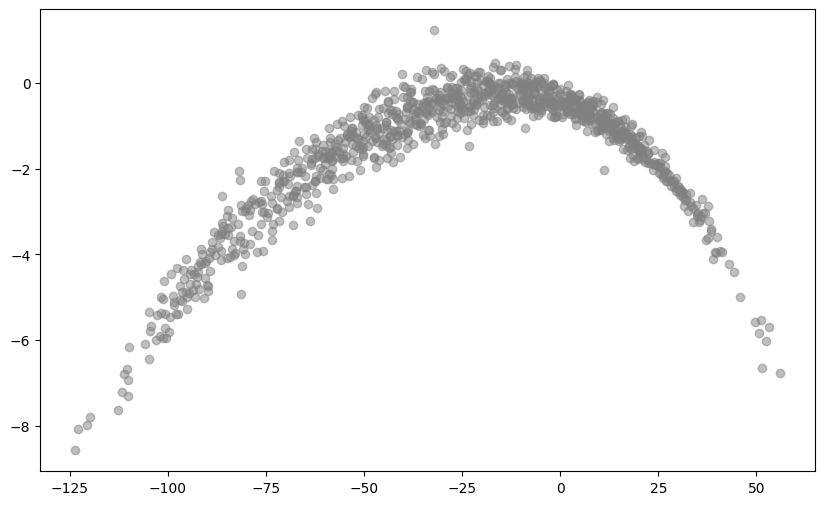

In [22]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

def run_simulation_debug(y):
    """
    Non-JIT version to debug masking, residuals, and chi2 contributions.
    Returns a dict with masks, filled coordinates, residuals, chi2.
    """
    # --- Example unpacking parameters ---
    Mvir, M_MN, r_s, a = y
    Mvir = 10**Mvir
    M_MN = 10**M_MN
    r_s = 10**r_s
    a = 10**a


    phi1_min, phi1_max = -100, 25
    phi2_min, phi2_max = -8, 2

    coord_indices = jnp.array([2, 3, 4, 5])


    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)

    #function that integrates the com backwards and forwards in time and then the stream, and projects it on the sky
    def assign_params_integrate_projection(t_end):
        

        new_params = params_sim._replace(
                    NFW_params=params_sim.NFW_params._replace(
                        Mvir=Mvir * u.Msun.to(code_units.code_mass), 
                        r_s=r_s * u.kpc.to(code_units.code_length)
                    ),
                    MN_params=params_sim.MN_params._replace(
                        M=M_MN * u.Msun.to(code_units.code_mass),
                        a=a * u.kpc.to(code_units.code_length)
                    ),
                     t_end = t_end,)
        snapshots = time_integration(initial_state_com, mass, config=config_com, params=new_params)
        stream_coordinate = jax.vmap(projection_on_GD1, in_axes=(0, None))(snapshots.states, code_units)
        return stream_coordinate

    t_end_mag = 0.2 * u.Gyr.to(code_units.code_time)
    t_end_array = jnp.array([-t_end_mag, t_end_mag])  # backward, forward
    

    # vmap over both parameters
    stream_coordinate_com = jax.vmap(assign_params_integrate_projection)(t_end_array)
    stream_coordinate_com_backward, stream_coordinate_com_forward = stream_coordinate_com[0], stream_coordinate_com[1]

    # Create masks for valid time steps
    mask_window_backward = (stream_coordinate_com_backward[:, 0, 1] < phi1_max) & \
                          (stream_coordinate_com_backward[:, 0, 1] > phi1_min) & \
                          (stream_coordinate_com_backward[:, 0, 2] < phi2_max) & \
                          (stream_coordinate_com_backward[:, 0, 2] > phi2_min)
    
    mask_diff_backward = jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1) > 0
    # New mask - True until first False appears
    mask_diff_backward = jnp.cumprod(mask_diff_backward, dtype=bool)


    mask_window_forward = (stream_coordinate_com_forward[:, 0, 1] < phi1_max) & \
                         (stream_coordinate_com_forward[:, 0, 1] > phi1_min) & \
                         (stream_coordinate_com_forward[:, 0, 2] < phi2_max) & \
                         (stream_coordinate_com_forward[:, 0, 2] > phi2_min)
    
    mask_diff_forward = jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=-1) < 0
    mask_diff_forward = jnp.cumprod(mask_diff_forward, dtype=bool)


    # Combined time step masks
    valid_time_backward = mask_window_backward & mask_diff_backward
    valid_time_forward = mask_window_forward & mask_diff_forward

    
    def forward_fill(arr, mask):
        """Forward-fill masked array: replace invalid entries with the last valid value."""
        mask_f = mask.astype(arr.dtype)
        arr_masked = jnp.where(mask, arr, 0.0)
        count = jnp.cumsum(mask_f)
        cumsum_vals = jnp.cumsum(arr_masked * mask_f)
        filled = jnp.where(count > 0, cumsum_vals / count, arr_masked)
        return filled

    def backward_fill(arr, mask):
        """Backward-fill masked array: replace invalid entries with the next valid value."""
        return forward_fill(arr[::-1], mask[::-1])[::-1]

    def smart_fill_by_phi(arr, mask, phi):
        """
        Choose fill direction based on monotonicity of `phi` along index:
        - if phi[-1] - phi[0] >= 0  -> use forward_fill (phi increasing)
        - else                     -> use backward_fill (phi decreasing)
        This is JAX-safe (uses lax.cond on a traced boolean).
        """
        # delta is a scalar (traced possible)
        delta = phi[1] - phi[0]

        # Use lax.cond to pick the branch in a JAX-traceable way
        return jax.lax.cond(delta >= 0.0,
                        lambda _: backward_fill(arr, mask),
                        lambda _: forward_fill(arr, mask),
                        operand=None)
    
    # Backward interpolation (inside run_simulation)

    phi1_backward_valid = smart_fill_by_phi(stream_coordinate_com_backward[:, 0, 1], valid_time_backward, stream_coordinate_com_backward[:, 0, 1])
    phi1_forward_valid = smart_fill_by_phi(stream_coordinate_com_forward[:, 0, 1], valid_time_forward, stream_coordinate_com_forward[:, 0, 1])

    # Create masked coordinates for interpolation (only valid time steps)
    # phi1_backward_valid = jnp.where(valid_time_backward, 
    #                                stream_coordinate_com_backward[:, 0, 1], 
    #                                10000.)
    
    
    # phi1_forward_valid = jnp.where(valid_time_forward, 
    #                               stream_coordinate_com_forward[:, 0, 1], 
    #                               -10000.)
    

    # Stream data masks - which data points to use for each direction
    mask_stream_backward = stream_data[:, 1] > stream_coordinate_com_backward[0, 0, 1]
    mask_stream_forward = stream_data[:, 1] < stream_coordinate_com_forward[0, 0, 1]

    mask_evaluate_inside_track_backward = (stream_data[:, 1] < jnp.max(phi1_backward_valid)) & (stream_data[:, 1] < phi1_max)
    mask_evaluate_inside_track_forward = (stream_data[:, 1] > jnp.min(phi1_forward_valid)) & (stream_data[:, 1] > phi1_min)

    # --- Interpolated coordinates (dummy here) ---
    # ---- Coordinate fill functions (JAX-friendly) ----
    def forward_fill_coord(y, mask):
        """
        For each index i:
        if mask[i] == True -> return y[i]
        else -> return y[last_valid_index_before_i]
        Implemented with cumsum + take so length is static and JAX-friendly.
        """
        n = y.shape[0]
        mask_i = mask.astype(jnp.int32)            # 1 where valid, 0 otherwise
        count = jnp.cumsum(mask_i)                 # running count of valid entries
        # index of last valid at or before i is count-1 (clip to 0..n-1)
        last_idx = jnp.clip(count - 1, 0, n - 1)   # shape (n,)
        # gather values at those indices
        last_vals = jnp.take(y, last_idx)
        # where count>0 use last_vals, else keep original y (or set to y[0]; choose y here)
        filled = jnp.where(count > 0, last_vals, y)
        return filled

    def backward_fill_coord(y, mask):
        """
        Fill invalid entries with the next valid value (first valid at or after i).
        Implemented by reversing and using forward_fill_coord.
        """
        y_rev = y[::-1]
        mask_rev = mask[::-1]
        filled_rev = forward_fill_coord(y_rev, mask_rev)
        return filled_rev[::-1]

    def smart_fill_coord_by_phi(y, mask, phi):
        """
        Choose fill direction based on phi monotonicity:
        - if phi[-1] - phi[0] >= 0: phi increases with index -> use forward_fill_coord
        - else: use backward_fill_coord
        Uses lax.cond to remain JAX-traceable.
        """
        delta = phi[-1] - phi[0]
        return jax.lax.cond(delta >= 0.0,
                            lambda _: forward_fill_coord(y, mask),
                            lambda _: backward_fill_coord(y, mask),
                            operand=None)

    def interpolate_coord_backward(coord_idx):
        """
        Use phi1_backward_valid as x_knots (full-length).
        Fill the coordinate values outside the valid mask using smart_fill_by_phi,
        then build Interpolator1D with extrap set to boundary y values.
        """
        # x knots: filled phi1 array (static length = n_snapshots)
        x_knots = phi1_backward_valid  # shape (n_snapshots,)
        # raw y along snapshots
        y_all = stream_coordinate_com_backward[:, 0, coord_idx]  # shape (n_snapshots,)
        # fill y outside mask according to phi monotonicity (keeps static shape)
        y_knots = smart_fill_coord_by_phi(y_all, valid_time_backward, stream_coordinate_com_backward[:, 0, 1])

        # number of valid knots (used only in conds)
        n_valid = jnp.sum(valid_time_backward).astype(jnp.int32)

        # query points (evaluate everywhere; residual mask later selects used ones)
        x_query = stream_data[:, 1]

        # branch on n_valid to handle 0/1/>=2 edge cases safely
        def no_knots():
            return jnp.zeros_like(x_query)

        def one_knot():
            first_idx = jnp.argmax(valid_time_backward)  # index of the single valid
            val = y_knots[first_idx]
            return jnp.full_like(x_query, val)

        def many_knots():
            # left/right fill from filled y_knots boundary values (time-ordered)
            left_fill = y_knots[0]
            right_fill = y_knots[-1]
            interp = Interpolator1D(x_knots, y_knots, extrap=(left_fill, right_fill))
            return interp(x_query)

        return jax.lax.cond(n_valid == 0,
                            no_knots,
                            lambda: jax.lax.cond(n_valid == 1, one_knot, many_knots))


    def interpolate_coord_forward(coord_idx):
        """
        Use phi1_forward_valid as x_knots (full-length).
        Fill the coordinate values outside the valid mask using smart_fill_by_phi,
        then build Interpolator1D with extrap set to boundary y values.
        """
        x_knots = phi1_forward_valid
        y_all = stream_coordinate_com_forward[:, 0, coord_idx]
        y_knots = smart_fill_coord_by_phi(y_all, valid_time_forward, stream_coordinate_com_forward[:, 0, 1])

        n_valid = jnp.sum(valid_time_forward).astype(jnp.int32)
        x_query = stream_data[:, 1]

        def no_knots():
            return jnp.zeros_like(x_query)

        def one_knot():
            first_idx = jnp.argmax(valid_time_forward)
            val = y_knots[first_idx]
            return jnp.full_like(x_query, val)

        def many_knots():
            left_fill = y_knots[0]
            right_fill = y_knots[-1]
            interp = Interpolator1D(x_knots, y_knots, extrap=(left_fill, right_fill))
            return interp(x_query)

        return jax.lax.cond(n_valid == 0,
                            no_knots,
                            lambda: jax.lax.cond(n_valid == 1, one_knot, many_knots))

        

    # Apply interpolation to all coordinates
    interp_tracks_backward = jax.vmap(interpolate_coord_backward)(coord_indices)  # Shape: (n_coords, n_data)
    interp_tracks_forward = jax.vmap(interpolate_coord_forward)(coord_indices)  # Shape: (n_coords, n_data)

    # --- Residuals ---
    data_coords = stream_data[:, coord_indices].T
    sigma = jnp.array([0.5, 10., 2., 2.])

    residuals_backward = (data_coords - interp_tracks_backward) / sigma[:, None]
    residuals_forward  = (data_coords - interp_tracks_forward) / sigma[:, None]
    # Masks for the data range where residuals make sense
    mask_in_backward = (
        mask_stream_backward &
        mask_evaluate_inside_track_backward &
        (stream_data[:, 1] < jnp.max(phi1_backward_valid)) &
        (stream_data[:, 1] > jnp.min(phi1_backward_valid))
    )

    mask_in_forward = (
        mask_stream_forward &
        mask_evaluate_inside_track_forward &
        (stream_data[:, 1] < jnp.max(phi1_forward_valid)) &
        (stream_data[:, 1] > jnp.min(phi1_forward_valid))
    )

    residuals_backward_masked = jnp.where(mask_in_backward[None, :], residuals_backward, 0.0)
    residuals_forward_masked  = jnp.where(mask_in_forward[None, :], residuals_forward, 0.0)

    chi2_backward = jnp.sum(residuals_backward_masked**2)
    chi2_forward  = jnp.sum(residuals_forward_masked**2)
    chi2 = chi2_backward + chi2_forward


    stream_b = stream_coordinate_com_backward[:, 0, :]
    stream_f = stream_coordinate_com_forward[:, 0, :]
    plt.figure(figsize=(10,6))
    plt.scatter(stream_data[:,1], stream_data[:,2],
                c='gray', alpha=0.5, label='stream_data')
    # Only points inside mask
    stream_b_masked = stream_b[valid_time_backward]
    stream_f_masked = stream_f[valid_time_forward]

    # Backward stream points inside mask
    # plt.scatter(stream_b_masked[:,1], stream_b_masked[:,2],
    #             c='r', marker='o', label='sim_backward')

    # # Forward stream points inside mask
    # plt.scatter(stream_f_masked[:,1], stream_f_masked[:,2],
    #             c='b', marker='^', label='sim_forward', edgecolors='k')

    # Interpolated tracks for phi2 (or any other coordinate) along phi1
    phi1_data = stream_data[:,1] # x-axis for interpolated tracks

    # Example: using coord index 2 (phi2) for plotting interpolated tracks
    coord_idx = 2
    interp_b = interp_tracks_backward[coord_idx]
    interp_f = interp_tracks_forward[coord_idx]
    len(interp_b)
    
    
    # Interpolated tracks along phi1
    plt.scatter(phi1_data, interp_b, 'r--', label='interp_backward')
    plt.scatter(phi1_data, interp_f, 'b--', label='interp_forward')

    plt.xlabel('phi1')
    plt.ylabel('phi2')
    plt.title('Stream vs Simulated Coordinates (color=mask)')
    plt.legend()
    plt.show()


    return {
        'residuals_backward': residuals_backward_masked,
        'residuals_forward': residuals_forward_masked,
        'mask_in_backward': mask_in_backward,
        'mask_in_forward': mask_in_forward,
        'phi1_backward_valid': phi1_backward_valid,
        'phi1_forward_valid': phi1_forward_valid,
        'chi2': chi2
    }

y0_batched = jnp.array([
    # Original array
    jnp.log10(params.NFW_params.Mvir * 2 * code_units.code_mass.to(u.Msun)), 
     jnp.log10(params.MN_params.M * 0.5 * code_units.code_mass.to(u.Msun)),
     jnp.log10(params.NFW_params.r_s * 2 * code_units.code_length.to(u.kpc)),
     jnp.log10(params.MN_params.a * 2 * code_units.code_length.to(u.kpc))],)
    

# Example usage:
debug_output = run_simulation_debug(y=y0_batched)


/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/chainconsumer/chain.py:313: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = rng.multivariate_normal(mean, covariance, size=1000000)  # type: ignore
/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/chainconsumer/chain.py:313: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = rng.multivariate_normal(mean, covariance, size=1000000)  # type: ignore
/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/chainconsumer/chain.py:313: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = rng.multivariate_normal(mean, covariance, size=1000000)  # type: ignore


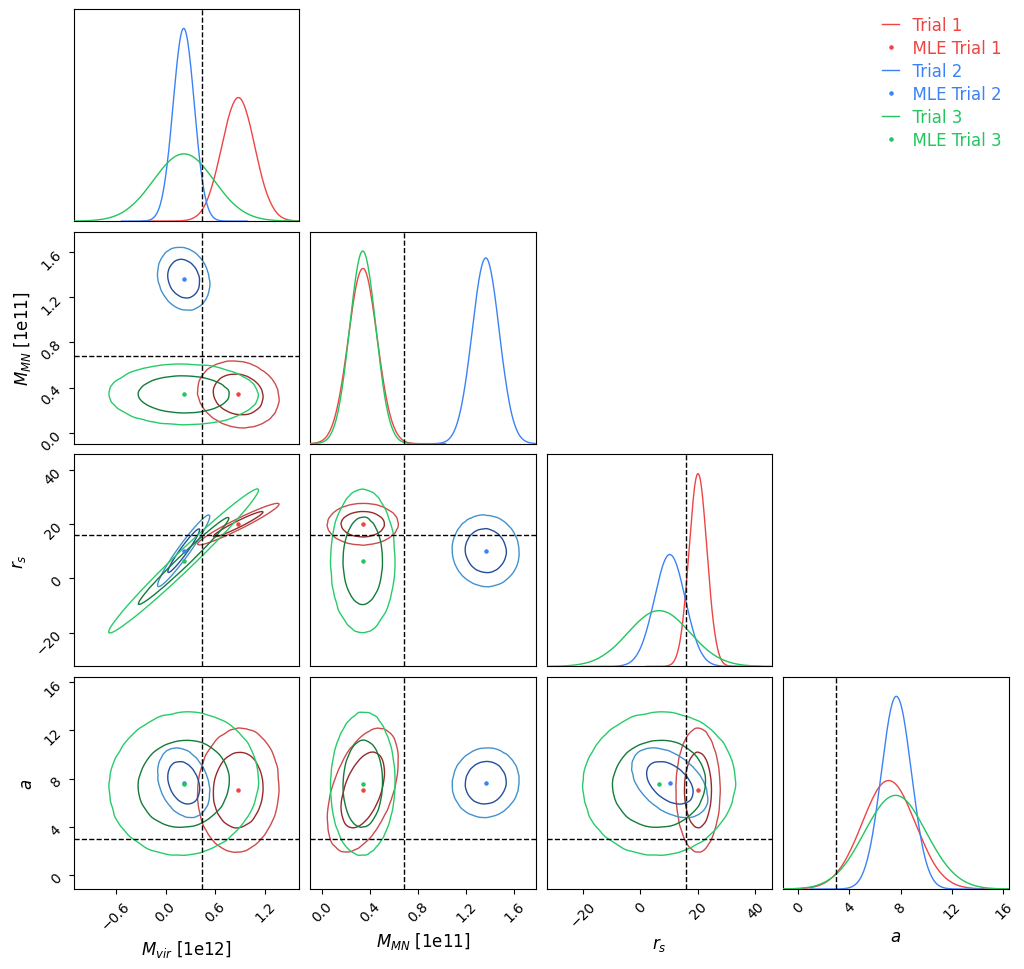

In [2]:
from chainconsumer import Chain, ChainConsumer, Truth

colors = ['red', 'blue', 'green', 'purple']
c = ChainConsumer()
for i in range(values.shape[0]):
    chain = Chain.from_covariance(mean=values[i], covariance=covariance[i], columns=["$M_{vir}$", "$M_{MN}$", "$r_s$", "$a$"], color=colors[i], name=f'Trial {i+1}')
    c.add_chain(chain)
    c.add_marker(location = {"$M_{vir}$": np.array(values[i][0]), "$M_{MN}$": np.array(values[i][1]),
                             "$r_s$": np.array(values[i][2]), "$a$": np.array(values[i][3])}, name=f"MLE Trial {i+1}",  color=colors[i], marker='x')

c.add_truth(Truth(location = {"$M_{vir}$": params.NFW_params.Mvir * code_units.code_mass.to(u.Msun), 
                              "$M_{MN}$": params.MN_params.M * code_units.code_mass.to(u.Msun),
                              "$r_s$": params.NFW_params.r_s * code_units.code_length.to(u.kpc),
                              "$a$": params.MN_params.a * code_units.code_length.to(u.kpc)}, color='black', name="True value"))

fig = c.plotter.plot()

In [6]:
config_com = config_com._replace(diffrax_adjoint_method=FORWARDMODE,)
J = jax.vmap(lambda v: jax.jacfwd(run_simulation)(v, True))(values)
F = jax.vmap(lambda x: x.T @ x)(J)

fisher_info =  F
covariance =  jax.vmap(jnp.linalg.inv)(fisher_info)

/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/chainconsumer/chain.py:313: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = rng.multivariate_normal(mean, covariance, size=1000000)  # type: ignore
/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/chainconsumer/chain.py:313: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = rng.multivariate_normal(mean, covariance, size=1000000)  # type: ignore


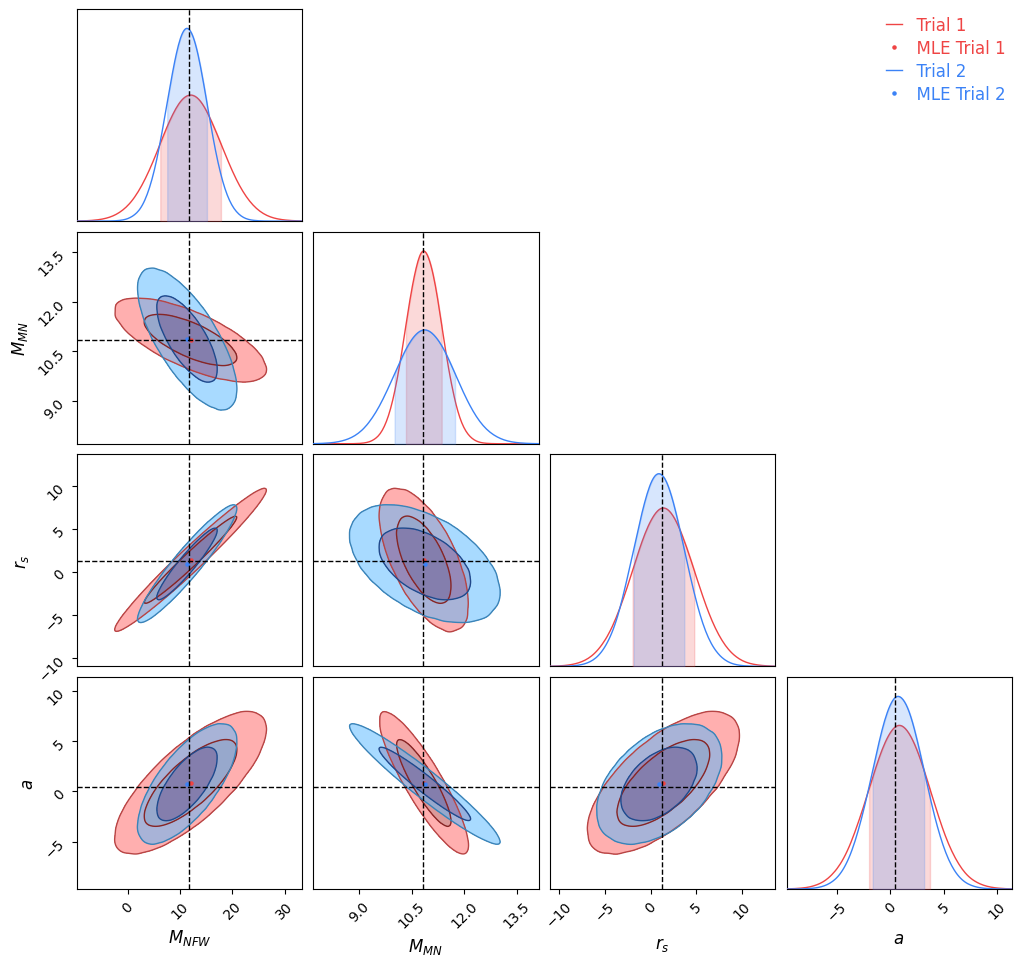

In [11]:
from chainconsumer import Chain, ChainConsumer, Truth

colors = ['red', 'blue', 'green', 'purple']
c = ChainConsumer()
for i in range(values.shape[0])[:-1]:
    chain = Chain.from_covariance(mean=values[i], covariance=covariance[i], columns=["$M_{NFW}$", "$M_{MN}$", "$r_s$", "$a$"], color=colors[i], name=f'Trial {i+1}')
    c.add_chain(chain)
    c.add_marker(location = {"$M_{NFW}$": np.array(values[i][0]), "$M_{MN}$": np.array(values[i][1]),
                             "$r_s$": np.array(values[i][2]), "$a$": np.array(values[i][3])}, name=f"MLE Trial {i+1}",  color=colors[i], marker='x')
c.add_truth(Truth(location = {"$M_{NFW}$": jnp.log10(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun)), 
                              "$M_{MN}$": jnp.log10(params.MN_params.M * code_units.code_mass.to(u.Msun)),
                              "$r_s$": jnp.log10(params.NFW_params.r_s * code_units.code_length.to(u.kpc)),
                              "$a$": jnp.log10(params.MN_params.a * code_units.code_length.to(u.kpc))}, color='black', name="True value"))

fig = c.plotter.plot()
# fig.savefig("Fisher_contour_least_square_vmap.png", dpi=300)

In [ ]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '2' 
from autocvd import autocvd
autocvd(num_gpus = 1)

import jax 
import jax.numpy as jnp
from jax import jit, random
import equinox as eqx
from jax.sharding import Mesh, PartitionSpec, NamedSharding

# jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt

from functools import partial

import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_LAXMAP, DIRECT_ACC_FOR_LOOP, DIRECT_ACC_MATRIX, NO_SELF_GRAVITY
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL, DIFFRAX_BACKEND, LEAPFROG
from odisseo.option_classes import SEMIIMPLICITEULER, TSIT5
from odisseo.option_classes import RECURSIVECHECKPOINTADJOING, FORWARDMODE
from odisseo.initial_condition import Plummer_sphere, Plummer_sphere_reparam
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot
from odisseo.potentials import MyamotoNagai, NFW

from odisseo.utils import halo_to_gd1_velocity_vmap, halo_to_gd1_vmap, projection_on_GD1
from jax.test_util import check_grads

plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

plt.style.use('default')


code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1, unit_time = code_time )  


config = SimulationConfig(N_particles = 1000, 
                          return_snapshots = True, 
                          num_snapshots = 1000, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.pc).to(code_units.code_length).value,
                          integrator = DIFFRAX_BACKEND,
                          differentation_mode=TSIT5,
                          fixed_timestep=False,
                          ) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.5 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 


key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)

#the center of mass needs to be integrated backwards in time first 
config_com = config._replace(N_particles=1,)
params_com = params._replace(t_end=-params.t_end,)

#this is the final position of the cluster, we need to integrate backwards in time 
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)


mass_com = jnp.array([params_com.Plummer_params.Mtot])
final_state_com = construct_initial_state(pos_com_final, vel_com_final)

snapshots_com = time_integration(final_state_com, mass_com, config_com, params_com)
pos_com, vel_com = snapshots_com.states[-1, :, 0], snapshots_com.states[-1, :, 1]


# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities)

#run the simulation
snapshots = time_integration(initial_state_stream, mass, config, params)

final_state = snapshots.states[-1]
stream_data = projection_on_GD1(final_state, code_units=code_units,)
print("Simulated GD1")


# LET'S TRY OPTIMIZING IT

params_sim = params
config_com = config_com._replace(diffrax_adjoint_method=FORWARDMODE,
)

from interpax import Interpolator1D
from functools import partial
from jax import jit, lax
import jax.numpy as jnp
import jax

@partial(jit, static_argnames=['return_residual'])
def run_simulation(y, return_residual=True):

    Mvir, M_MN, r_s, a = y

    phi1_min, phi1_max = -100, 25
    phi2_min, phi2_max = -8, 2

    coord_indices = jnp.array([2, 3, 4, 5])

    # Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5, -254.5, -90.3]]) * (u.km / u.s).to(code_units.code_velocity)

    # construct the initial state of the com
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final)

    # function that integrates the com backwards and forwards in time and then the stream, and projects it on the sky
    @jit
    def assign_params_integrate_projection(t_end):

        new_params = params_sim._replace(
            NFW_params=params_sim.NFW_params._replace(
                Mvir=Mvir * u.Msun.to(code_units.code_mass),
                r_s=r_s * u.kpc.to(code_units.code_length)
            ),
            MN_params=params_sim.MN_params._replace(
                M=M_MN * u.Msun.to(code_units.code_mass),
                a=a * u.kpc.to(code_units.code_length)
            ),
            t_end=t_end,
        )
        snapshots = time_integration(initial_state_com, mass, config=config_com, params=new_params)
        stream_coordinate = jax.vmap(projection_on_GD1, in_axes=(0, None))(snapshots.states, code_units)
        return stream_coordinate

    t_end_mag = 0.2 * u.Gyr.to(code_units.code_time)
    t_end_array = jnp.array([-t_end_mag, t_end_mag])  # backward, forward

    # vmap over both parameters
    stream_coordinate_com = jax.vmap(assign_params_integrate_projection)(t_end_array)
    stream_coordinate_com_backward, stream_coordinate_com_forward = stream_coordinate_com[0], stream_coordinate_com[1]

    # Create masks for valid time steps
    mask_window_backward = (stream_coordinate_com_backward[:, 0, 1] < phi1_max) & \
                          (stream_coordinate_com_backward[:, 0, 1] > phi1_min) & \
                          (stream_coordinate_com_backward[:, 0, 2] < phi2_max) & \
                          (stream_coordinate_com_backward[:, 0, 2] > phi2_min)

    mask_diff_backward = jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1) > 0
    # New mask - True until first False appears
    mask_diff_backward = jnp.cumprod(mask_diff_backward, dtype=bool)

    mask_window_forward = (stream_coordinate_com_forward[:, 0, 1] < phi1_max) & \
                         (stream_coordinate_com_forward[:, 0, 1] > phi1_min) & \
                         (stream_coordinate_com_forward[:, 0, 2] < phi2_max) & \
                         (stream_coordinate_com_forward[:, 0, 2] > phi2_min)

    mask_diff_forward = jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=-1) < 0
    mask_diff_forward = jnp.cumprod(mask_diff_forward, dtype=bool)

    # Combined time step masks
    valid_time_backward = mask_window_backward & mask_diff_backward
    valid_time_forward = mask_window_forward & mask_diff_forward

    # -------------------------
    # Forward/Backward fill phi1 arrays
    # -------------------------
    def forward_fill(arr, mask):
        """Forward-fill masked array: replace invalid entries with the last valid value."""
        mask_f = mask.astype(jnp.float32)
        arr_masked = jnp.where(mask, arr, 0.0)
        count = jnp.cumsum(mask_f)
        cumsum_vals = jnp.cumsum(arr_masked * mask_f)
        filled = jnp.where(count > 0, cumsum_vals / count, arr_masked)
        return filled

    def backward_fill(arr, mask):
        """Backward-fill masked array: replace invalid entries with the next valid value."""
        return forward_fill(arr[::-1], mask[::-1])[::-1]

    phi1_backward_valid = forward_fill(stream_coordinate_com_backward[:, 0, 1], valid_time_backward)
    phi1_forward_valid = backward_fill(stream_coordinate_com_forward[:, 0, 1], valid_time_forward)

    # Stream data masks - which data points to use for each direction
    mask_stream_backward = stream_data[:, 1] > stream_coordinate_com_backward[0, 0, 1]
    mask_stream_forward = stream_data[:, 1] < stream_coordinate_com_forward[0, 0, 1]

    mask_evaluate_inside_track_backward = (stream_data[:, 1] < jnp.max(phi1_backward_valid)) & (stream_data[:, 1] < phi1_max)
    mask_evaluate_inside_track_forward = (stream_data[:, 1] > jnp.min(phi1_forward_valid)) & (stream_data[:, 1] > phi1_min)

    # --- replace the Safe Interpolator/build_and_call + interpolation functions with this ---

    def build_and_call_interpolator_full(x_all, y_all, mask_valid, x_query):
        """
        Use full-length x_all,y_all arrays (snapshot-length). y_all is filled outside mask
        with the last available valid value so the array length stays static.
        mask_valid: boolean mask for valid knots (contiguous prefix/suffix in your case)
        x_query: query points (stream_data[:,1])
        """
        # number of valid knots (traced scalar used only inside lax.cond)
        n_valid = jnp.sum(mask_valid).astype(jnp.int32)

        def no_knots():
            return jnp.zeros_like(x_query)

        def one_knot():
            # find index of first valid (safe: if only one valid, this returns its index)
            first_idx = jnp.argmax(mask_valid)
            val = y_all[first_idx]
            return jnp.full_like(x_query, val)

        def many_knots():
            # Use filled y_all (same length as x_all). left/right fill are boundaries of filled array.
            # For backward direction you used forward_fill so y_all[0] (or [-1]) are correct
            left_fill = y_all[0]
            right_fill = y_all[-1]
            # Construct interpolator on the entire grid (x_all must be monotonic across snapshots).
            interp = Interpolator1D(x_all, y_all, extrap=(left_fill, right_fill))
            return interp(x_query)

        # branch safely
        return jax.lax.cond(n_valid == 0, no_knots, lambda: jax.lax.cond(n_valid == 1, one_knot, many_knots))


    # Backward interpolation using filled y (forward-fill for suffix)
    def interpolate_coord_backward(coord_idx):
        x_all = stream_coordinate_com_backward[:, 0, 1]   # phi1 at each snapshot (monotonic in time)
        y_all = stream_coordinate_com_backward[:, 0, coord_idx]

        # mask_valid: prefix True until first invalid (your valid_time_backward)
        mask_valid = valid_time_backward

        # Fill y_all after the last valid with last valid value (keeps array length static)
        y_all_filled = forward_fill(y_all, mask_valid)

        # Query points: evaluate at all stream_data phi1 (residual mask will later select used ones)
        x_query = stream_data[:, 1]

        return build_and_call_interpolator_full(x_all, y_all_filled, mask_valid, x_query)


    # Forward interpolation using filled y (backward-fill for prefix)
    def interpolate_coord_forward(coord_idx):
        x_all = stream_coordinate_com_forward[:, 0, 1]
        y_all = stream_coordinate_com_forward[:, 0, coord_idx]

        mask_valid = valid_time_forward
        # Fill y_all before the first valid with next valid value (keeps array length static)
        y_all_filled = backward_fill(y_all, mask_valid)

        x_query = stream_data[:, 1]
        return build_and_call_interpolator_full(x_all, y_all_filled, mask_valid, x_query)


    # Apply interpolation to all coordinates
    interp_tracks_backward = jax.vmap(interpolate_coord_backward)(coord_indices)  # Shape: (n_coords, n_data)
    interp_tracks_forward = jax.vmap(interpolate_coord_forward)(coord_indices)  # Shape: (n_coords, n_data)

    # Calculate residuals for all coordinates
    data_coords = stream_data[:, coord_indices].T  # Shape: (n_coords, n_data)
    sigma = jnp.array([0.5, 10., 2., 2.])

    mask_correct_interpolation_backward = phi1_backward_valid < 20
    mask_correct_interpolation_forward = phi1_forward_valid > -95

    # Calculate chi2 using only the appropriate data points for each direction
    residuals_backward = jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward,
                                  (data_coords - interp_tracks_backward) / sigma[:, None],
                                  0.0)
    residuals_forward = jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward,
                                 (data_coords - interp_tracks_forward) / sigma[:, None],
                                 0.0)

    chi2_backward = jnp.sum(residuals_backward**2)
    chi2_forward = jnp.sum(residuals_forward**2)

    chi2 = chi2_backward + chi2_forward

    if return_residual:
        return jnp.concatenate([residuals_backward**2, residuals_forward**2], axis=0).flatten()
    else:
        return chi2

    

print("beginning least square optimization")

from optimistix import least_squares
import optimistix


# Shape will be (4, 4)

y0_batched = jnp.array([
    # Original array
    [params.NFW_params.Mvir * 2 * code_units.code_mass.to(u.Msun), 
     params.MN_params.M * 0.5 * code_units.code_mass.to(u.Msun),
     params.NFW_params.r_s * 2 * code_units.code_length.to(u.kpc),
     params.MN_params.a * 2 * code_units.code_length.to(u.kpc)],
    
    # Variation 1: swap some factors
    # [jnp.log10(params.NFW_params.Mvir * 0.5 * code_units.code_mass.to(u.Msun)), 
    #  jnp.log10(params.MN_params.M * 2 * code_units.code_mass.to(u.Msun)),
    #  jnp.log10(params.NFW_params.r_s * 0.5 * code_units.code_length.to(u.kpc)),
    #  jnp.log10(params.MN_params.a * 2 * code_units.code_length.to(u.kpc))],
    
    # Variation 2: different swaps
    # [jnp.log10(params.NFW_params.Mvir * 0.5 * code_units.code_mass.to(u.Msun)), 
    #  jnp.log10(params.MN_params.M * 0.5 * code_units.code_mass.to(u.Msun)),
    #  jnp.log10(params.NFW_params.r_s * 0.5 * code_units.code_length.to(u.kpc)),
    #  jnp.log10(params.MN_params.a * 0.5 * code_units.code_length.to(u.kpc))],
    
    # Variation 3: more swaps
    # [jnp.log10(params.NFW_params.Mvir * 0.5 * code_units.code_mass.to(u.Msun)), 
    #  jnp.log10(params.MN_params.M * 0.5 * code_units.code_mass.to(u.Msun)),
    #  jnp.log10(params.NFW_params.r_s * 2 * code_units.code_length.to(u.kpc)),
    #  jnp.log10(params.MN_params.a * 0.5 * code_units.code_length.to(u.kpc))],
])

# Shape will be (4, 4)
def minimization_vmap(y0):
    return least_squares(
        fn=run_simulation,
        solver=optimistix.LevenbergMarquardt(rtol=1e-5, atol=1e-5),
        y0=y0,
    ).value

values = jax.vmap(minimization_vmap)(y0_batched)


#remember to put FORWARD MODE for the adjoint method when calculating the hessian
config_com = config_com._replace(diffrax_adjoint_method=FORWARDMODE,)
hessians = jax.vmap(lambda v: jax.jacfwd(jax.jacfwd(run_simulation))(v, False))(values)


fisher_info =  hessians
covariance = 2.0 * jax.vmap(jnp.linalg.inv)(fisher_info)

from chainconsumer import Chain, ChainConsumer, Truth

colors = ['red', 'blue', 'green', 'purple']
c = ChainConsumer()
for i in range(values.shape[0]):
    chain = Chain.from_covariance(mean=values[i], covariance=covariance[i], columns=["$M_{vir}$", "$M_{MN}$", "$r_s$", "$a$"], color=colors[i], name=f'Trial {i+1}')
    c.add_chain(chain)
    c.add_marker(location = {"$M_{vir}$": np.array(values[i][0]), "$M_{MN}$": np.array(values[i][1]),
                             "$r_s$": np.array(values[i][2]), "$a$": np.array(values[i][3])}, name=f"MLE Trial {i+1}",  color=colors[i], marker='x')

c.add_truth(Truth(location = {"$M_{vir}$": params.NFW_params.Mvir * code_units.code_mass.to(u.Msun), 
                              "$M_{MN}$": params.MN_params.M * code_units.code_mass.to(u.Msun),
                              "$r_s$": params.NFW_params.r_s * code_units.code_length.to(u.kpc),
                              "$a$": params.MN_params.a * code_units.code_length.to(u.kpc)}, color='black', name="True value"))

fig = c.plotter.plot()
# fig.savefig("Fisher_contour_least_square_vmap.png", dpi=300)

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
Simulated GD1
beginning least square optimization


ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: traced array with shape int32[]
The size argument of jnp.nonzero must be statically specified to use jnp.nonzero within JAX transformations.
The error occurred while tracing the function run_simulation at /tmp/ipykernel_3226838/3990013741.py:130 for jit. This concrete value was not available in Python because it depends on the value of the argument y.

See https://docs.jax.dev/en/latest/errors.html#jax.errors.ConcretizationTypeError

Simulated GD1
beginning least square optimization


/export/home/vgiusepp/miniconda3/envs/sbi_sim/lib/python3.12/site-packages/chainconsumer/chain.py:313: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = rng.multivariate_normal(mean, covariance, size=1000000)  # type: ignore


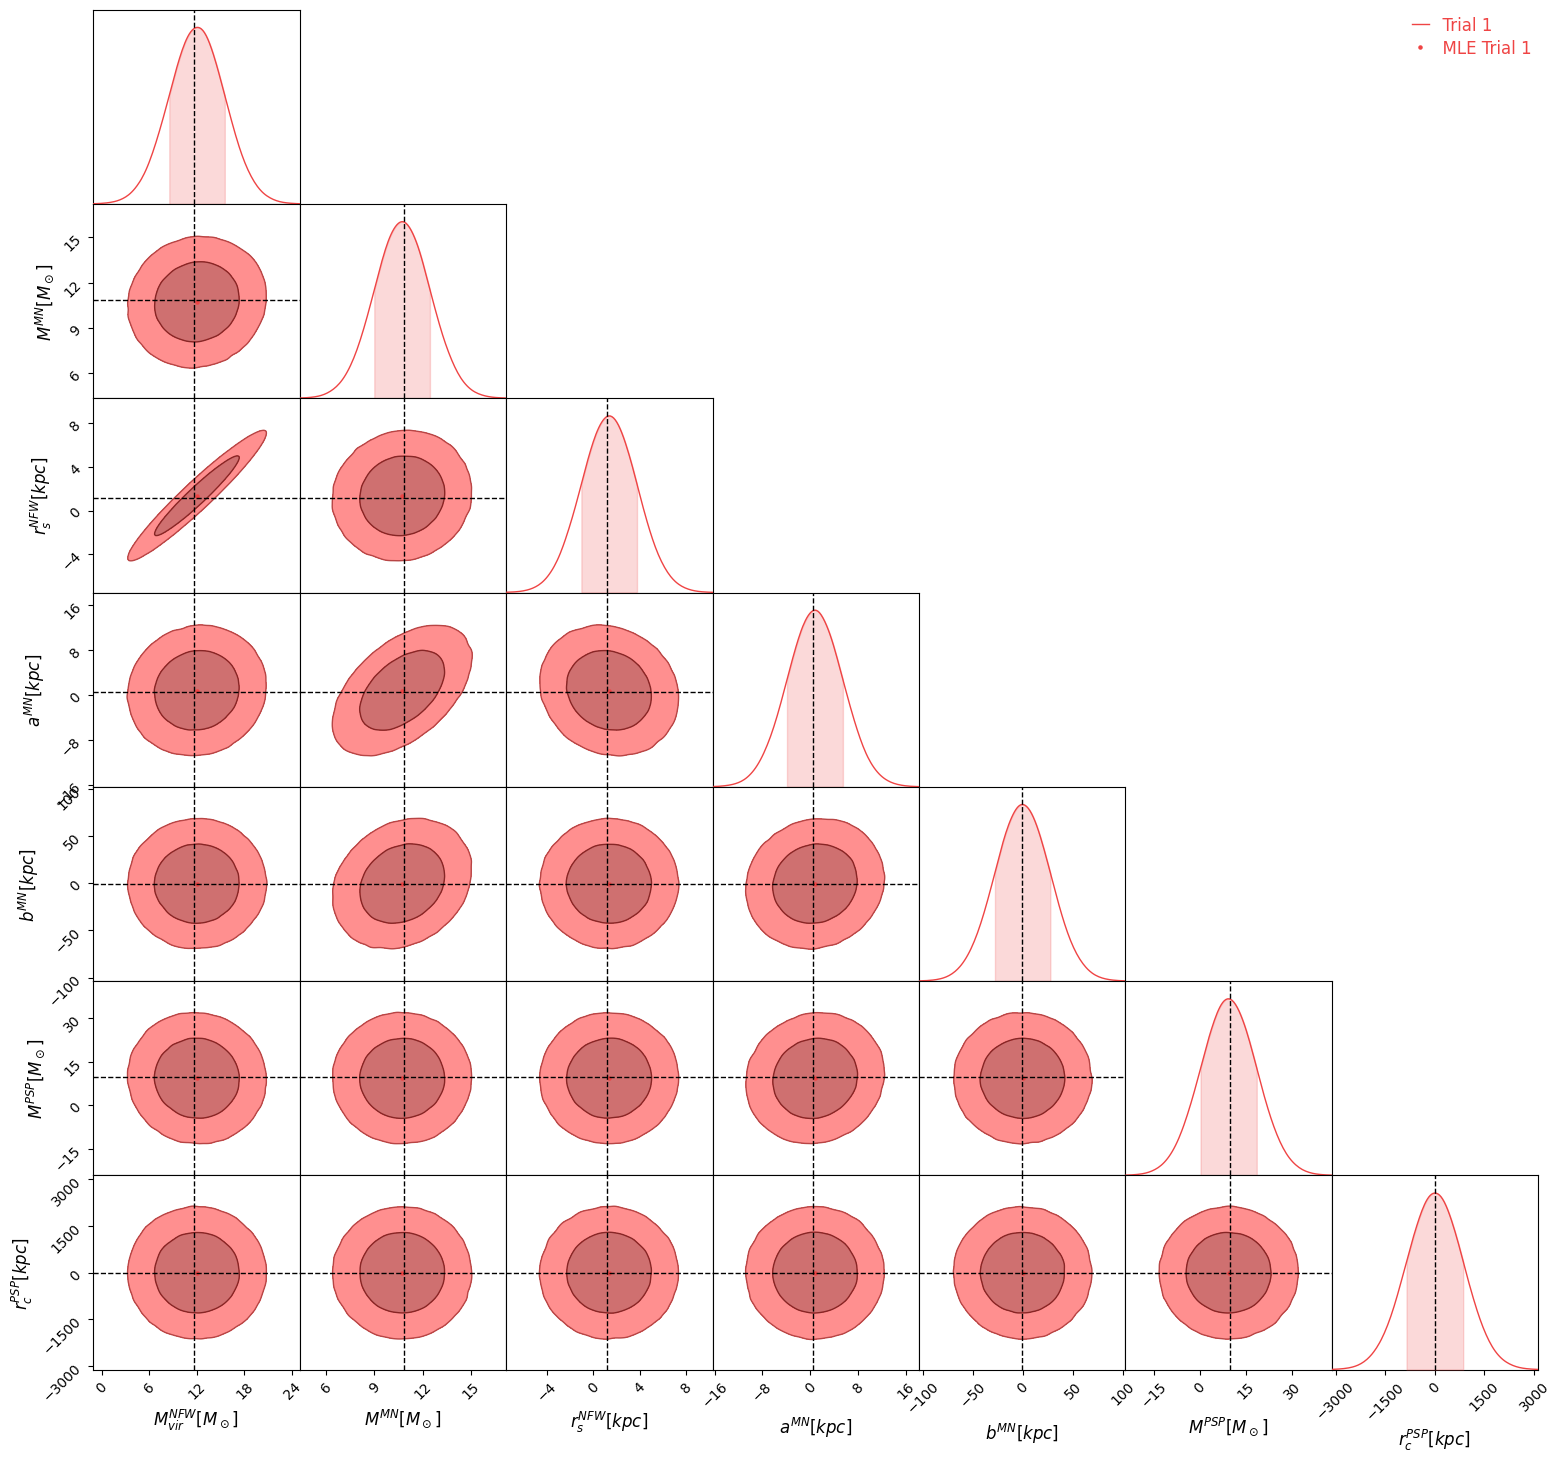

In [22]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '2' 
from autocvd import autocvd
autocvd(num_gpus = 1)

import jax 
import jax.numpy as jnp
from jax import jit, random
import equinox as eqx
from jax.sharding import Mesh, PartitionSpec, NamedSharding

# jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt

from functools import partial

import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_LAXMAP, DIRECT_ACC_FOR_LOOP, DIRECT_ACC_MATRIX, NO_SELF_GRAVITY
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL, DIFFRAX_BACKEND, LEAPFROG
from odisseo.option_classes import SEMIIMPLICITEULER, TSIT5
from odisseo.option_classes import RECURSIVECHECKPOINTADJOING, FORWARDMODE
from odisseo.initial_condition import Plummer_sphere, Plummer_sphere_reparam
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot
from odisseo.potentials import MyamotoNagai, NFW

from odisseo.utils import halo_to_gd1_velocity_vmap, halo_to_gd1_vmap, projection_on_GD1
from jax.test_util import check_grads

plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

plt.style.use('default')


code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1, unit_time = code_time )  


config = SimulationConfig(N_particles = 1000, 
                          return_snapshots = True, 
                          num_snapshots = 1000, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.pc).to(code_units.code_length).value,
                          integrator = DIFFRAX_BACKEND,
                          differentation_mode=TSIT5,
                          fixed_timestep=False,
                          ) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.5 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 


key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)

#the center of mass needs to be integrated backwards in time first 
config_com = config._replace(N_particles=1,)
params_com = params._replace(t_end=-params.t_end,)

#this is the final position of the cluster, we need to integrate backwards in time 
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)


mass_com = jnp.array([params_com.Plummer_params.Mtot])
final_state_com = construct_initial_state(pos_com_final, vel_com_final)

snapshots_com = time_integration(final_state_com, mass_com, config_com, params_com)
pos_com, vel_com = snapshots_com.states[-1, :, 0], snapshots_com.states[-1, :, 1]


# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities)

#run the simulation
snapshots = time_integration(initial_state_stream, mass, config, params)

final_state = snapshots.states[-1]
stream_data = projection_on_GD1(final_state, code_units=code_units,)
print("Simulated GD1")


# LET'S TRY OPTIMIZING IT

params_sim = params
config_com = config_com._replace(diffrax_adjoint_method=FORWARDMODE,
)

@partial(jit, static_argnames=['return_residual'])
def run_simulation( y, return_residual=True):

    Mvir, M_MN, r_s, a, b, M_PSP, r_c_P = y
    Mvir = 10**Mvir
    M_MN = 10**M_MN
    r_s = 10**r_s
    a = 10**a
    b = 10**b
    M_PSP = 10**M_PSP
    r_c_P = 10**r_c_P

    

    phi1_min, phi1_max = -100, 25
    phi2_min, phi2_max = -8, 2

    coord_indices = jnp.array([2, 3, 4, 5])


    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)

    #function that integrates the com backwards and forwards in time and then the stream, and projects it on the sky
    @jit
    def assign_params_integrate_projection(t_end):
        

        new_params = params_sim._replace(
                    NFW_params=params_sim.NFW_params._replace(
                        Mvir=Mvir * u.Msun.to(code_units.code_mass), 
                        r_s=r_s * u.kpc.to(code_units.code_length)
                    ),
                    MN_params=params_sim.MN_params._replace(
                        M=M_MN * u.Msun.to(code_units.code_mass),
                        a=a * u.kpc.to(code_units.code_length),
                        b=b * u.kpc.to(code_units.code_length),
                    ),
                    PSP_params=params_sim.PSP_params._replace(
                        M=M_PSP * u.Msun.to(code_units.code_mass),
                        r_c=r_c_P * u.kpc.to(code_units.code_length)
                    ),
                     t_end = t_end,)
        snapshots = time_integration(initial_state_com, mass, config=config_com, params=new_params)
        stream_coordinate = jax.vmap(projection_on_GD1, in_axes=(0, None))(snapshots.states, code_units)
        return stream_coordinate

    t_end_mag = 0.5 * u.Gyr.to(code_units.code_time)
    t_end_array = jnp.array([-t_end_mag, t_end_mag])  # backward, forward
    

    # vmap over both parameters
    stream_coordinate_com = jax.vmap(assign_params_integrate_projection)(t_end_array)
    stream_coordinate_com_backward, stream_coordinate_com_forward = stream_coordinate_com[0], stream_coordinate_com[1]


    # Create masks for valid time steps
    mask_window_backward = (stream_coordinate_com_backward[:, 0, 1] < phi1_max) & \
                          (stream_coordinate_com_backward[:, 0, 1] > phi1_min) & \
                          (stream_coordinate_com_backward[:, 0, 2] < phi2_max) & \
                          (stream_coordinate_com_backward[:, 0, 2] > phi2_min)
    
    mask_diff_backward = jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1) > 0
    # New mask - True until first False appears
    mask_diff_backward = jnp.cumprod(mask_diff_backward, dtype=bool)


    mask_window_forward = (stream_coordinate_com_forward[:, 0, 1] < phi1_max) & \
                         (stream_coordinate_com_forward[:, 0, 1] > phi1_min) & \
                         (stream_coordinate_com_forward[:, 0, 2] < phi2_max) & \
                         (stream_coordinate_com_forward[:, 0, 2] > phi2_min)
    
    mask_diff_forward = jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=-1) < 0
    mask_diff_forward = jnp.cumprod(mask_diff_forward, dtype=bool)


    # Combined time step masks
    valid_time_backward = mask_window_backward & mask_diff_backward
    valid_time_forward = mask_window_forward & mask_diff_forward

    # Create masked coordinates for interpolation (only valid time steps)
    phi1_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, 1], 
                                   10000.)
    
    
    phi1_forward_valid = jnp.where(valid_time_forward, 
                                  stream_coordinate_com_forward[:, 0, 1], 
                                  -10000.)
    

    # Stream data masks - which data points to use for each direction
    mask_stream_backward = stream_data[:, 1] > stream_coordinate_com_backward[0, 0, 1]
    mask_stream_forward = stream_data[:, 1] < stream_coordinate_com_forward[0, 0, 1]

    mask_evaluate_inside_track_backward = (stream_data[:, 1] < jnp.max(phi1_backward_valid)) & (stream_data[:, 1] < phi1_max)
    mask_evaluate_inside_track_forward = (stream_data[:, 1] > jnp.min(phi1_forward_valid)) & (stream_data[:, 1] > phi1_min)

    def interpolate_coord_backward(coord_idx):

        coord_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, coord_idx], 
                                   -100000.0)

        return jnp.interp(
            jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward, stream_data[:, 1], 100000.0), 
            phi1_backward_valid, 
            coord_backward_valid
        )
    
    def interpolate_coord_forward(coord_idx):

        coord_forward_valid = jnp.where(valid_time_forward, 
                                   stream_coordinate_com_forward[:, 0, coord_idx], 
                                   100000.0)

        return jnp.interp(
            -jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward, stream_data[:, 1], -100000.0), 
            -phi1_forward_valid, 
            coord_forward_valid
        )
        

    # Apply interpolation to all coordinates
    interp_tracks_backward = jax.vmap(interpolate_coord_backward)(coord_indices)  # Shape: (n_coords, n_data)
    interp_tracks_forward = jax.vmap(interpolate_coord_forward)(coord_indices)  # Shape: (n_coords, n_data)

    # Calculate residuals for all coordinates
    data_coords = stream_data[:, coord_indices].T  # Shape: (n_coords, n_data)
    sigma = jnp.array([0.5, 10., 2., 2. ])
    # sigma = jnp.array([0.15, 5., 0.1, 0.0001]) #from albatross

    
    mask_correct_interpolation_backward = phi1_backward_valid < 20
    mask_correct_interpolation_forward = phi1_forward_valid > - 95

    # Calculate chi2 using only the appropriate data points for each direction
    residuals_backward = jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward, 
                                  (data_coords - interp_tracks_backward)/sigma[:, None],
                                   0.)
    residuals_forward = jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward, 
                                 (data_coords - interp_tracks_forward)/sigma[:, None],
                                  0.)
    
    # chi2_backward = jnp.sum(residuals_backward**2) 
    # chi2_forward = jnp.sum(residuals_forward**2) 
    
    # # Use only backward for now (as in your original code)
    # chi2 = chi2_backward + chi2_forward

    # if return_residual:
    #     return jnp.concatenate([residuals_backward**2, residuals_forward**2], axis=0).flatten()
    # else:
    #     return chi2
    # Count effective measurements
    # Each masked point contributes 4 coordinates (phi2, v_phi1, v_phi2, v_radial)
    
    # Masks for valid residuals
    mask_backward_full = mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward
    mask_forward_full = mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward
    
    n_eff_backward = jnp.nansum(mask_backward_full) * 4
    n_eff_forward = jnp.nansum(mask_forward_full) * 4
    n_total = n_eff_backward + n_eff_forward
    
    # Chi-squared
    chi2 = jnp.sum(residuals_backward**2) + jnp.sum(residuals_forward**2)
    
    # Reduced chi-squared (normalized by degrees of freedom)
    n_params = 7  # or 4, depending on which version you're using
    dof = jnp.maximum(n_total - n_params, 1.0)
    reduced_chi2 = chi2 / dof
    
    if return_residual:
        # Return residuals divided by sqrt(dof) for proper scaling
        all_residuals = jnp.concatenate([residuals_backward, residuals_forward], axis=1).flatten()
        return all_residuals / jnp.sqrt(dof)
    else:
        return reduced_chi2

print("beginning least square optimization")

from optimistix import least_squares
import optimistix


# Shape will be (4, 4)

y0_batched = jnp.array([
    # Original array
    [jnp.log10(params.NFW_params.Mvir * 2 * code_units.code_mass.to(u.Msun)), 
     jnp.log10(params.MN_params.M * 0.5 * code_units.code_mass.to(u.Msun)),
     jnp.log10(params.NFW_params.r_s * 2 * code_units.code_length.to(u.kpc)),
     jnp.log10(params.MN_params.a * 2 * code_units.code_length.to(u.kpc)),
     jnp.log10(params.MN_params.b * 2 * code_units.code_length.to(u.kpc)),
     jnp.log10(params.PSP_params.M * 0.5 * code_units.code_mass.to(u.Msun)),
     jnp.log10(params.PSP_params.r_c * 2 * code_units.code_length.to(u.kpc))
     ],
    
    # # Variation 1: swap some factors
    # [jnp.log10(params.NFW_params.Mvir * 0.5 * code_units.code_mass.to(u.Msun)), 
    #  jnp.log10(params.MN_params.M * 2 * code_units.code_mass.to(u.Msun)),
    #  jnp.log10(params.NFW_params.r_s * 0.5 * code_units.code_length.to(u.kpc)),
    #  jnp.log10(params.MN_params.a * 2 * code_units.code_length.to(u.kpc)),
    #  jnp.log10(params.MN_params.b * 0.5 * code_units.code_length.to(u.kpc)),
    #  jnp.log10(params.PSP_params.M * 2 * code_units.code_mass.to(u.Msun)),
    #  jnp.log10(params.PSP_params.r_c * 0.5 * code_units.code_length.to(u.kpc))
    #  ],
    
    ## Variation 2: different swaps
    # [jnp.log10(params.NFW_params.Mvir * 2 * code_units.code_mass.to(u.Msun)), 
    #  jnp.log10(params.MN_params.M * 2 * code_units.code_mass.to(u.Msun)),
    #  jnp.log10(params.NFW_params.r_s * 2 * code_units.code_length.to(u.kpc)),
    #  jnp.log10(params.MN_params.a * 2 * code_units.code_length.to(u.kpc)),
    #  jnp.log10(params.MN_params.b * 2 * code_units.code_length.to(u.kpc)),
    #  jnp.log10(params.PSP_params.M * 2 * code_units.code_mass.to(u.Msun)),
    #  jnp.log10(params.PSP_params.r_c * 2 * code_units.code_length.to(u.kpc))
    #  ],
    
    # Variation 3: more swaps
    # [jnp.log10(params.NFW_params.Mvir * 0.5 * code_units.code_mass.to(u.Msun)), 
    #  jnp.log10(params.MN_params.M * 0.5 * code_units.code_mass.to(u.Msun)),
    #  jnp.log10(params.NFW_params.r_s * 2 * code_units.code_length.to(u.kpc)),
    #  jnp.log10(params.MN_params.a * 0.5 * code_units.code_length.to(u.kpc)),
    #  jnp.log10(params.MN_params.b * 0.5 * code_units.code_length.to(u.kpc)),
    #  jnp.log10(params.PSP_params.M * 2 * code_units.code_mass.to(u.Msun)),
    #  jnp.log10(params.PSP_params.r_c * 2 * code_units.code_length.to(u.kpc))
    #  ],
])

# Shape will be (4, 4)
def minimization_vmap(y0):
    return least_squares(
        fn=run_simulation,
        solver=optimistix.LevenbergMarquardt(rtol=1e-5, atol=1e-5),
        y0=y0,
    ).value

values = jax.vmap(minimization_vmap)(y0_batched)


#remember to put FORWARD MODE for the adjoint method when calculating the hessian
config_com = config_com._replace(diffrax_adjoint_method=FORWARDMODE,)
hessians = jax.vmap(lambda v: jax.jacfwd(jax.jacfwd(run_simulation))(v, False))(values)


fisher_info = - hessians
covariance = jax.vmap(jnp.linalg.inv)(fisher_info)


from chainconsumer import Chain, ChainConsumer, Truth

colors = ['red', 'blue', 'green', 'purple']
c = ChainConsumer()
for i in range(values.shape[0]):
    chain = Chain.from_covariance(mean=values[i], covariance=covariance[i], columns=["$M_{vir}^{NFW} [M_\odot]$", "$M^{MN} [M_\odot]$", "$r_s^{NFW} [kpc]$", "$a^{MN} [kpc]$", "$b^{MN} [kpc]$", "$M^{PSP} [M_\odot]$", "$r_c^{PSP} [kpc]$"], color=colors[i], name=f'Trial {i+1}')
    c.add_chain(chain)
    c.add_marker(location = {"$M_{vir}^{NFW} [M_\odot]$": np.array(values[i][0]), "$M^{MN} [M_\odot]$": np.array(values[i][1]),
                             "$r_s^{NFW} [kpc]$": np.array(values[i][2]), "$a^{MN} [kpc]$": np.array(values[i][3]), "$b^{MN} [kpc]$": np.array(values[i][4]),
                             "$M^{PSP} [M_\odot]$": np.array(values[i][5]), "$r_c^{PSP} [kpc]$": np.array(values[i][6])}, name=f"MLE Trial {i+1}",  color=colors[i], marker='x')

c.add_truth(Truth(location = {"$M_{vir}^{NFW} [M_\odot]$": jnp.log10(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun)), 
                              "$M^{MN} [M_\odot]$": jnp.log10(params.MN_params.M * code_units.code_mass.to(u.Msun)),
                              "$r_s^{NFW} [kpc]$": jnp.log10(params.NFW_params.r_s * code_units.code_length.to(u.kpc)),
                              "$a^{MN} [kpc]$": jnp.log10(params.MN_params.a * code_units.code_length.to(u.kpc)),
                              "$b^{MN} [kpc]$": jnp.log10(params.MN_params.b * code_units.code_length.to(u.kpc)),
                              "$M^{PSP} [M_\odot]$": jnp.log10(params.PSP_params.M * code_units.code_mass.to(u.Msun)),
                              "$r_c^{PSP} [kpc]$": jnp.log10(params.PSP_params.r_c * code_units.code_length.to(u.kpc))}, 
                              color='black', name="True value"))

fig = c.plotter.plot()
fig.savefig("Fisher_contour_least_square_AllParameters_vmap.png", dpi=300)

Simulated GD1
beginning least square optimization


/export/home/vgiusepp/miniconda3/envs/sbi_sim/lib/python3.12/site-packages/chainconsumer/chain.py:313: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = rng.multivariate_normal(mean, covariance, size=1000000)  # type: ignore


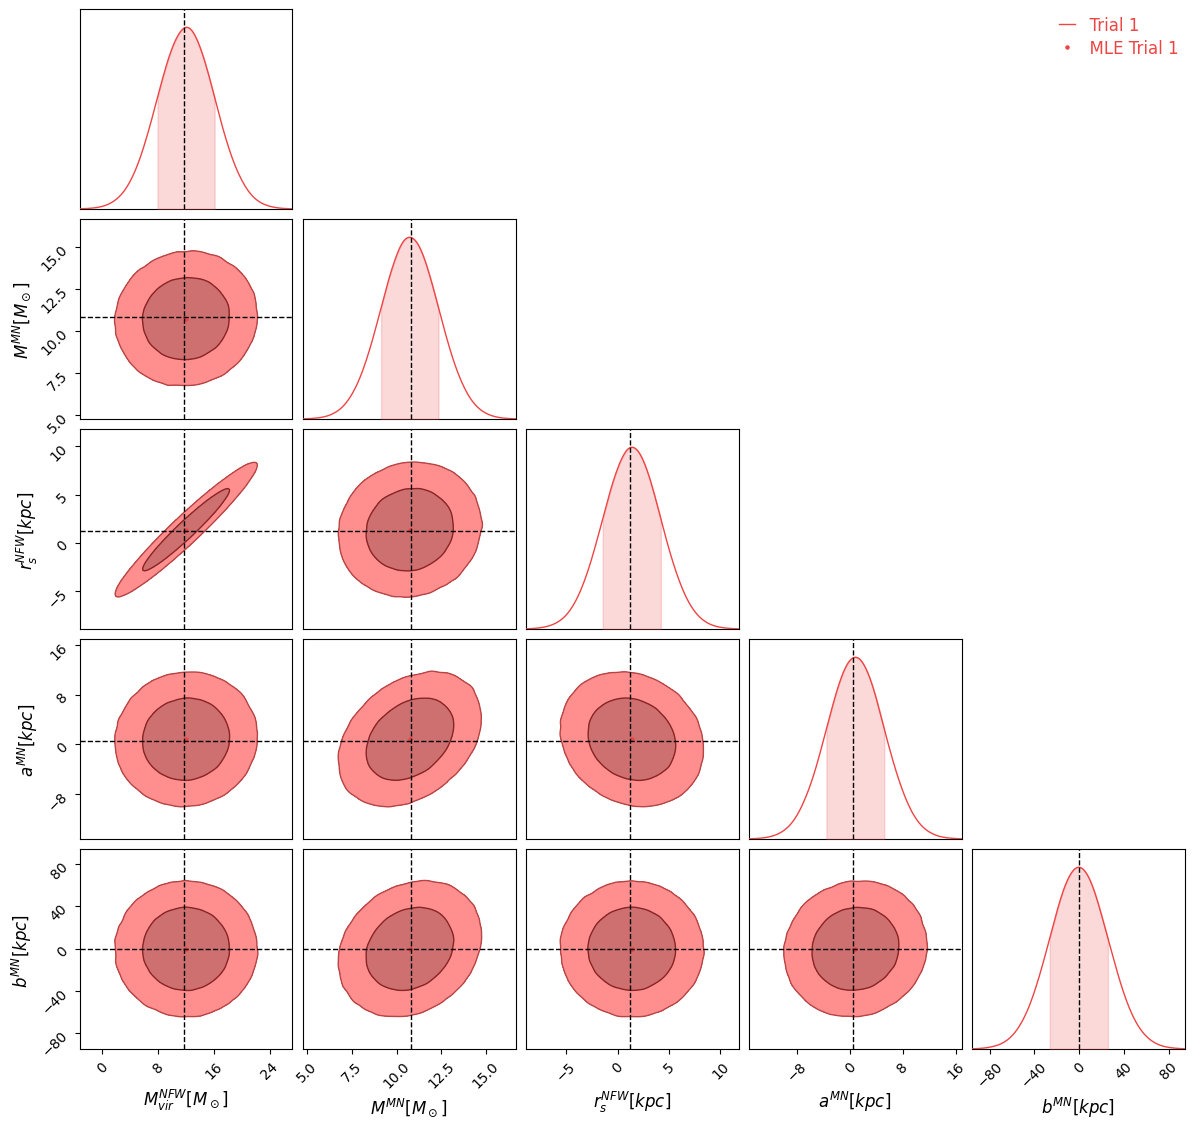

In [ ]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '2' 
from autocvd import autocvd
autocvd(num_gpus = 1)

import jax 
import jax.numpy as jnp
from jax import jit, random
import equinox as eqx
from jax.sharding import Mesh, PartitionSpec, NamedSharding

# jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt

from functools import partial

import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_LAXMAP, DIRECT_ACC_FOR_LOOP, DIRECT_ACC_MATRIX, NO_SELF_GRAVITY
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL, DIFFRAX_BACKEND, LEAPFROG
from odisseo.option_classes import SEMIIMPLICITEULER, TSIT5
from odisseo.option_classes import RECURSIVECHECKPOINTADJOING, FORWARDMODE
from odisseo.initial_condition import Plummer_sphere, Plummer_sphere_reparam
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot
from odisseo.potentials import MyamotoNagai, NFW

from odisseo.utils import halo_to_gd1_velocity_vmap, halo_to_gd1_vmap, projection_on_GD1
from jax.test_util import check_grads

plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

plt.style.use('default')


code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1, unit_time = code_time )  


config = SimulationConfig(N_particles = 1000, 
                          return_snapshots = True, 
                          num_snapshots = 1000, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.pc).to(code_units.code_length).value,
                          integrator = DIFFRAX_BACKEND,
                          differentation_mode=TSIT5,
                          fixed_timestep=False,
                          ) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.5 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 


key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)

#the center of mass needs to be integrated backwards in time first 
config_com = config._replace(N_particles=1,)
params_com = params._replace(t_end=-params.t_end,)

#this is the final position of the cluster, we need to integrate backwards in time 
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)


mass_com = jnp.array([params_com.Plummer_params.Mtot])
final_state_com = construct_initial_state(pos_com_final, vel_com_final)

snapshots_com = time_integration(final_state_com, mass_com, config_com, params_com)
pos_com, vel_com = snapshots_com.states[-1, :, 0], snapshots_com.states[-1, :, 1]


# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities)

#run the simulation
snapshots = time_integration(initial_state_stream, mass, config, params)

final_state = snapshots.states[-1]
stream_data = projection_on_GD1(final_state, code_units=code_units,)
print("Simulated GD1")


# LET'S TRY OPTIMIZING IT

params_sim = params
config_com = config_com._replace(diffrax_adjoint_method=FORWARDMODE,
)

@partial(jit, static_argnames=['return_residual'])
def run_simulation( y, return_residual=True):

    Mvir, M_MN, r_s, a, b, = y
    Mvir = 10**Mvir
    M_MN = 10**M_MN
    r_s = 10**r_s
    a = 10**a
    b = 10**b


    

    phi1_min, phi1_max = -100, 25
    phi2_min, phi2_max = -8, 2

    coord_indices = jnp.array([2, 3, 4, 5])


    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)

    #function that integrates the com backwards and forwards in time and then the stream, and projects it on the sky
    @jit
    def assign_params_integrate_projection(t_end):
        

        new_params = params_sim._replace(
                    NFW_params=params_sim.NFW_params._replace(
                        Mvir=Mvir * u.Msun.to(code_units.code_mass), 
                        r_s=r_s * u.kpc.to(code_units.code_length)
                    ),
                    MN_params=params_sim.MN_params._replace(
                        M=M_MN * u.Msun.to(code_units.code_mass),
                        a=a * u.kpc.to(code_units.code_length),
                        b=b * u.kpc.to(code_units.code_length),
                    ),
                     t_end = t_end,)
        snapshots = time_integration(initial_state_com, mass, config=config_com, params=new_params)
        stream_coordinate = jax.vmap(projection_on_GD1, in_axes=(0, None))(snapshots.states, code_units)
        return stream_coordinate

    t_end_mag = 0.5 * u.Gyr.to(code_units.code_time)
    t_end_array = jnp.array([-t_end_mag, t_end_mag])  # backward, forward
    

    # vmap over both parameters
    stream_coordinate_com = jax.vmap(assign_params_integrate_projection)(t_end_array)
    stream_coordinate_com_backward, stream_coordinate_com_forward = stream_coordinate_com[0], stream_coordinate_com[1]


    # Create masks for valid time steps
    mask_window_backward = (stream_coordinate_com_backward[:, 0, 1] < phi1_max) & \
                          (stream_coordinate_com_backward[:, 0, 1] > phi1_min) & \
                          (stream_coordinate_com_backward[:, 0, 2] < phi2_max) & \
                          (stream_coordinate_com_backward[:, 0, 2] > phi2_min)
    
    mask_diff_backward = jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1) > 0
    # New mask - True until first False appears
    mask_diff_backward = jnp.cumprod(mask_diff_backward, dtype=bool)


    mask_window_forward = (stream_coordinate_com_forward[:, 0, 1] < phi1_max) & \
                         (stream_coordinate_com_forward[:, 0, 1] > phi1_min) & \
                         (stream_coordinate_com_forward[:, 0, 2] < phi2_max) & \
                         (stream_coordinate_com_forward[:, 0, 2] > phi2_min)
    
    mask_diff_forward = jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=-1) < 0
    mask_diff_forward = jnp.cumprod(mask_diff_forward, dtype=bool)


    # Combined time step masks
    valid_time_backward = mask_window_backward & mask_diff_backward
    valid_time_forward = mask_window_forward & mask_diff_forward

    # Create masked coordinates for interpolation (only valid time steps)
    phi1_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, 1], 
                                   10000.)
    
    
    phi1_forward_valid = jnp.where(valid_time_forward, 
                                  stream_coordinate_com_forward[:, 0, 1], 
                                  -10000.)
    

    # Stream data masks - which data points to use for each direction
    mask_stream_backward = stream_data[:, 1] > stream_coordinate_com_backward[0, 0, 1]
    mask_stream_forward = stream_data[:, 1] < stream_coordinate_com_forward[0, 0, 1]

    mask_evaluate_inside_track_backward = (stream_data[:, 1] < jnp.max(phi1_backward_valid)) & (stream_data[:, 1] < phi1_max)
    mask_evaluate_inside_track_forward = (stream_data[:, 1] > jnp.min(phi1_forward_valid)) & (stream_data[:, 1] > phi1_min)

    def interpolate_coord_backward(coord_idx):

        coord_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, coord_idx], 
                                   -100000.0)

        return jnp.interp(
            jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward, stream_data[:, 1], 100000.0), 
            phi1_backward_valid, 
            coord_backward_valid
        )
    
    def interpolate_coord_forward(coord_idx):

        coord_forward_valid = jnp.where(valid_time_forward, 
                                   stream_coordinate_com_forward[:, 0, coord_idx], 
                                   100000.0)

        return jnp.interp(
            -jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward, stream_data[:, 1], -100000.0), 
            -phi1_forward_valid, 
            coord_forward_valid
        )
        

    # Apply interpolation to all coordinates
    interp_tracks_backward = jax.vmap(interpolate_coord_backward)(coord_indices)  # Shape: (n_coords, n_data)
    interp_tracks_forward = jax.vmap(interpolate_coord_forward)(coord_indices)  # Shape: (n_coords, n_data)

    # Calculate residuals for all coordinates
    data_coords = stream_data[:, coord_indices].T  # Shape: (n_coords, n_data)
    sigma = jnp.array([0.5, 10., 2., 2. ])
    # sigma = jnp.array([0.15, 5., 0.1, 0.0001]) #from albatross

    
    mask_correct_interpolation_backward = phi1_backward_valid < 20
    mask_correct_interpolation_forward = phi1_forward_valid > - 95

    # Calculate chi2 using only the appropriate data points for each direction
    residuals_backward = jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward, 
                                  (data_coords - interp_tracks_backward)/sigma[:, None],
                                   0.)
    residuals_forward = jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward, 
                                 (data_coords - interp_tracks_forward)/sigma[:, None],
                                  0.)
    
    # chi2_backward = jnp.sum(residuals_backward**2) 
    # chi2_forward = jnp.sum(residuals_forward**2) 
    
    # # Use only backward for now (as in your original code)
    # chi2 = chi2_backward + chi2_forward

    # if return_residual:
    #     return jnp.concatenate([residuals_backward**2, residuals_forward**2], axis=0).flatten()
    # else:
    #     return chi2
    # Count effective measurements
    # Each masked point contributes 4 coordinates (phi2, v_phi1, v_phi2, v_radial)
    
    # Masks for valid residuals
    mask_backward_full = mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward
    mask_forward_full = mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward
    
    n_eff_backward = jnp.nansum(mask_backward_full) * 4
    n_eff_forward = jnp.nansum(mask_forward_full) * 4
    n_total = n_eff_backward + n_eff_forward
    
    # Chi-squared
    chi2 = jnp.sum(residuals_backward**2) + jnp.sum(residuals_forward**2)
    
    # Reduced chi-squared (normalized by degrees of freedom)
    n_params = 7  # or 4, depending on which version you're using
    dof = jnp.maximum(n_total - n_params, 1.0)
    reduced_chi2 = chi2 / dof
    
    if return_residual:
        # Return residuals divided by sqrt(dof) for proper scaling
        all_residuals = jnp.concatenate([residuals_backward, residuals_forward], axis=1).flatten()
        return all_residuals / jnp.sqrt(dof)
    else:
        return reduced_chi2

print("beginning least square optimization")

from optimistix import least_squares
import optimistix


# Shape will be (4, 4)

y0_batched = jnp.array([
    # Original array
    [jnp.log10(params.NFW_params.Mvir * 2 * code_units.code_mass.to(u.Msun)), 
     jnp.log10(params.MN_params.M * 0.5 * code_units.code_mass.to(u.Msun)),
     jnp.log10(params.NFW_params.r_s * 2 * code_units.code_length.to(u.kpc)),
     jnp.log10(params.MN_params.a * 2 * code_units.code_length.to(u.kpc)),
     jnp.log10(params.MN_params.b * 2 * code_units.code_length.to(u.kpc)),
     ],
    
    # # Variation 1: swap some factors
    # [jnp.log10(params.NFW_params.Mvir * 0.5 * code_units.code_mass.to(u.Msun)), 
    #  jnp.log10(params.MN_params.M * 2 * code_units.code_mass.to(u.Msun)),
    #  jnp.log10(params.NFW_params.r_s * 0.5 * code_units.code_length.to(u.kpc)),
    #  jnp.log10(params.MN_params.a * 2 * code_units.code_length.to(u.kpc)),
    #  jnp.log10(params.MN_params.b * 0.5 * code_units.code_length.to(u.kpc)),
    #  ],
    
    # Variation 2: different swaps
    # [jnp.log10(params.NFW_params.Mvir * 2 * code_units.code_mass.to(u.Msun)), 
    #  jnp.log10(params.MN_params.M * 2 * code_units.code_mass.to(u.Msun)),
    #  jnp.log10(params.NFW_params.r_s * 2 * code_units.code_length.to(u.kpc)),
    #  jnp.log10(params.MN_params.a * 2 * code_units.code_length.to(u.kpc)),
    #  jnp.log10(params.MN_params.b * 2 * code_units.code_length.to(u.kpc)),
    #  ],
    
    # Variation 3: more swaps
    # [jnp.log10(params.NFW_params.Mvir * 0.5 * code_units.code_mass.to(u.Msun)), 
    #  jnp.log10(params.MN_params.M * 0.5 * code_units.code_mass.to(u.Msun)),
    #  jnp.log10(params.NFW_params.r_s * 2 * code_units.code_length.to(u.kpc)),
    #  jnp.log10(params.MN_params.a * 0.5 * code_units.code_length.to(u.kpc)),
    #  jnp.log10(params.MN_params.b * 0.5 * code_units.code_length.to(u.kpc)),
    #  ],
])

# Shape will be (4, 4)
def minimization_vmap(y0):
    return least_squares(
        fn=run_simulation,
        solver=optimistix.LevenbergMarquardt(rtol=1e-5, atol=1e-5),
        y0=y0,
    ).value

values = jax.vmap(minimization_vmap)(y0_batched)


#remember to put FORWARD MODE for the adjoint method when calculating the hessian
config_com = config_com._replace(diffrax_adjoint_method=FORWARDMODE,)
hessians = jax.vmap(lambda v: jax.jacfwd(jax.jacfwd(run_simulation))(v, False))(values)


fisher_info = - hessians
covariance = jax.vmap(jnp.linalg.inv)(fisher_info)


from chainconsumer import Chain, ChainConsumer, Truth, PlotConfig

colors = ['red', 'blue', 'green', 'purple']
c = ChainConsumer()
for i in range(values.shape[0]):
    chain = Chain.from_covariance(mean=values[i], 
                                  covariance=covariance[i], 
                                  columns=["$M_{vir}^{NFW} [M_\odot]$", "$M^{MN} [M_\odot]$", "$r_s^{NFW} [kpc]$", "$a^{MN} [kpc]$", "$b^{MN} [kpc]$"], 
                                  color="emerald",  
                                  name=f'Fisher contours',
                                  show_contour_labels=True,
                                  shade_alpha=0.7
    )

    c.add_chain(chain)
    c.add_marker(location = {"$M_{vir}^{NFW} [M_\odot]$": np.array(values[i][0]), "$M^{MN} [M_\odot]$": np.array(values[i][1]),
                             "$r_s^{NFW} [kpc]$": np.array(values[i][2]), "$a^{MN} [kpc]$": np.array(values[i][3]), "$b^{MN} [kpc]$": np.array(values[i][4]),
                             }, color="black", name='MLE', marker_style='P', marker_size=50)

c.add_truth(Truth(location = {"$M_{vir}^{NFW} [M_\odot]$": jnp.log10(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun)), 
                              "$M^{MN} [M_\odot]$": jnp.log10(params.MN_params.M * code_units.code_mass.to(u.Msun)),
                              "$r_s^{NFW} [kpc]$": jnp.log10(params.NFW_params.r_s * code_units.code_length.to(u.kpc)),
                              "$a^{MN} [kpc]$": jnp.log10(params.MN_params.a * code_units.code_length.to(u.kpc)),
                              "$b^{MN} [kpc]$": jnp.log10(params.MN_params.b * code_units.code_length.to(u.kpc)),
                              }, 
                              color='black', name="True value"))
c.set_plot_config(
    PlotConfig(
        max_ticks=4,
        label_font_size=20,
        tick_font_size=15,
        summary_font_size=20,

))
fig = c.plotter.plot()
fig.savefig("Fisher_contour_least_square_AllParameters_vmap.png", dpi=300)

/export/home/vgiusepp/miniconda3/envs/sbi_sim/lib/python3.12/site-packages/chainconsumer/chain.py:313: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = rng.multivariate_normal(mean, covariance, size=1000000)  # type: ignore


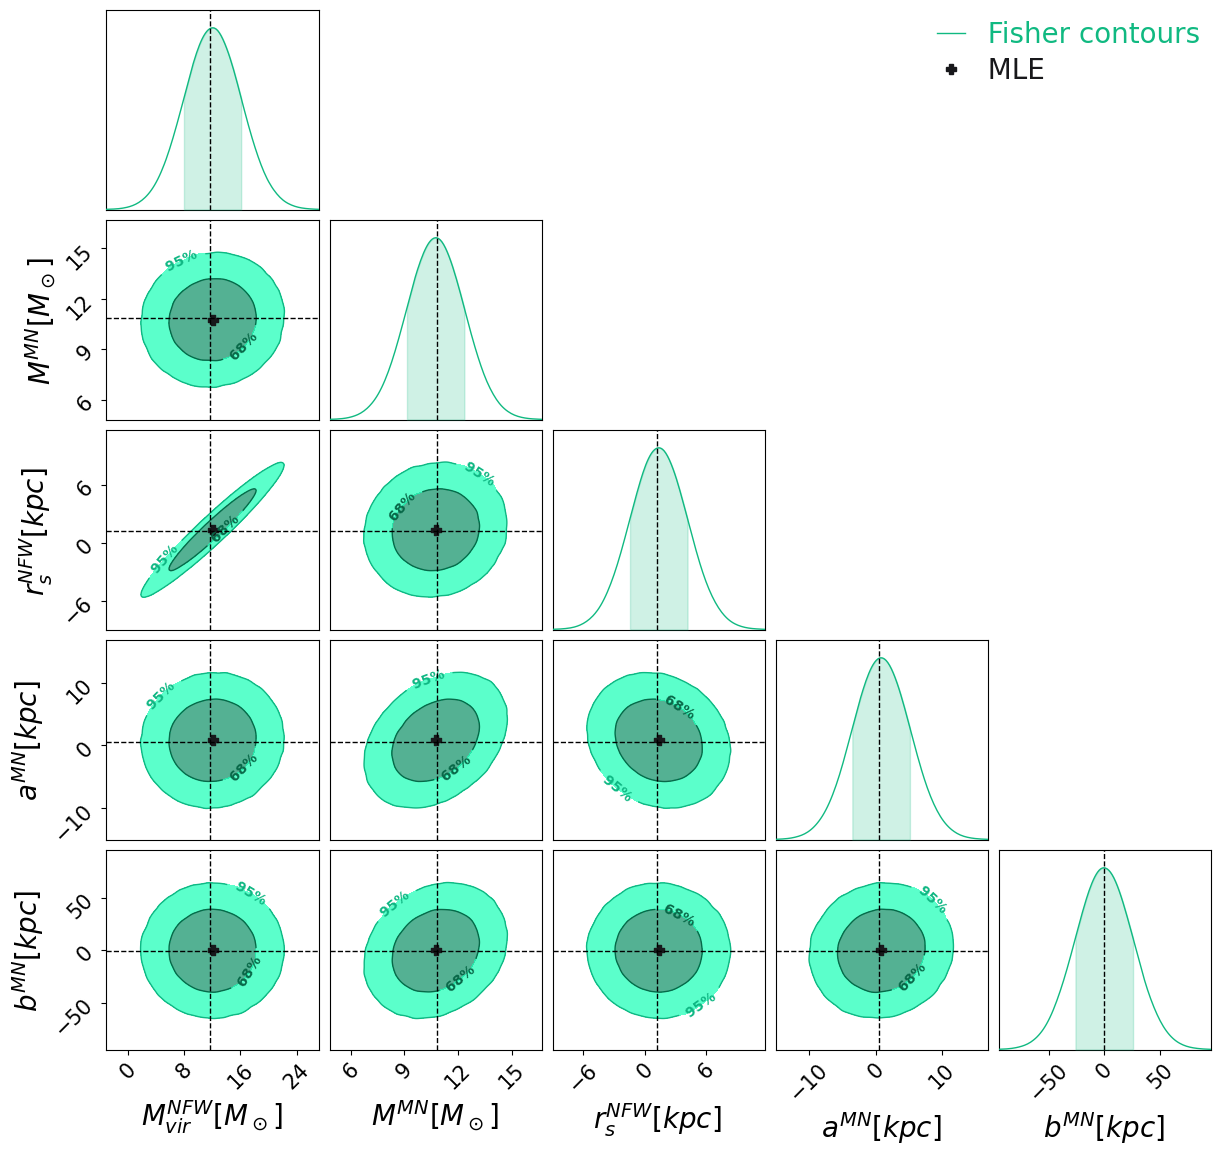

In [ ]:
from chainconsumer import Chain, ChainConsumer, Truth, PlotConfig

colors = ['red', 'blue', 'green', 'purple']
c = ChainConsumer()
for i in range(values.shape[0]):
    chain = Chain.from_covariance(mean=values[i], 
                                  covariance=covariance[i], 
                                  columns=["$M_{vir}^{NFW} [M_\odot]$", "$M^{MN} [M_\odot]$", "$r_s^{NFW} [kpc]$", "$a^{MN} [kpc]$", "$b^{MN} [kpc]$"], 
                                  color="emerald",  
                                  name=f'Fisher contours',
                                  show_contour_labels=True,
                                  shade_alpha=0.7
    )

    c.add_chain(chain)
    c.add_marker(location = {"$M_{vir}^{NFW} [M_\odot]$": np.array(values[i][0]), "$M^{MN} [M_\odot]$": np.array(values[i][1]),
                             "$r_s^{NFW} [kpc]$": np.array(values[i][2]), "$a^{MN} [kpc]$": np.array(values[i][3]), "$b^{MN} [kpc]$": np.array(values[i][4]),
                             }, color="black", name='MLE', marker_style='P', marker_size=50)

c.add_truth(Truth(location = {"$M_{vir}^{NFW} [M_\odot]$": jnp.log10(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun)), 
                              "$M^{MN} [M_\odot]$": jnp.log10(params.MN_params.M * code_units.code_mass.to(u.Msun)),
                              "$r_s^{NFW} [kpc]$": jnp.log10(params.NFW_params.r_s * code_units.code_length.to(u.kpc)),
                              "$a^{MN} [kpc]$": jnp.log10(params.MN_params.a * code_units.code_length.to(u.kpc)),
                              "$b^{MN} [kpc]$": jnp.log10(params.MN_params.b * code_units.code_length.to(u.kpc)),
                              }, 
                              color='black', name="True value"))
c.set_plot_config(
    PlotConfig(
        max_ticks=4,
        label_font_size=20,
        tick_font_size=15,
        summary_font_size=20,

))
fig = c.plotter.plot()
fig.savefig("Fisher_contour_least_square_AllParameters_vmap.png", dpi=300)

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
Simulated GD1
beginning least square optimization


/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/chainconsumer/chain.py:313: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = rng.multivariate_normal(mean, covariance, size=1000000)  # type: ignore


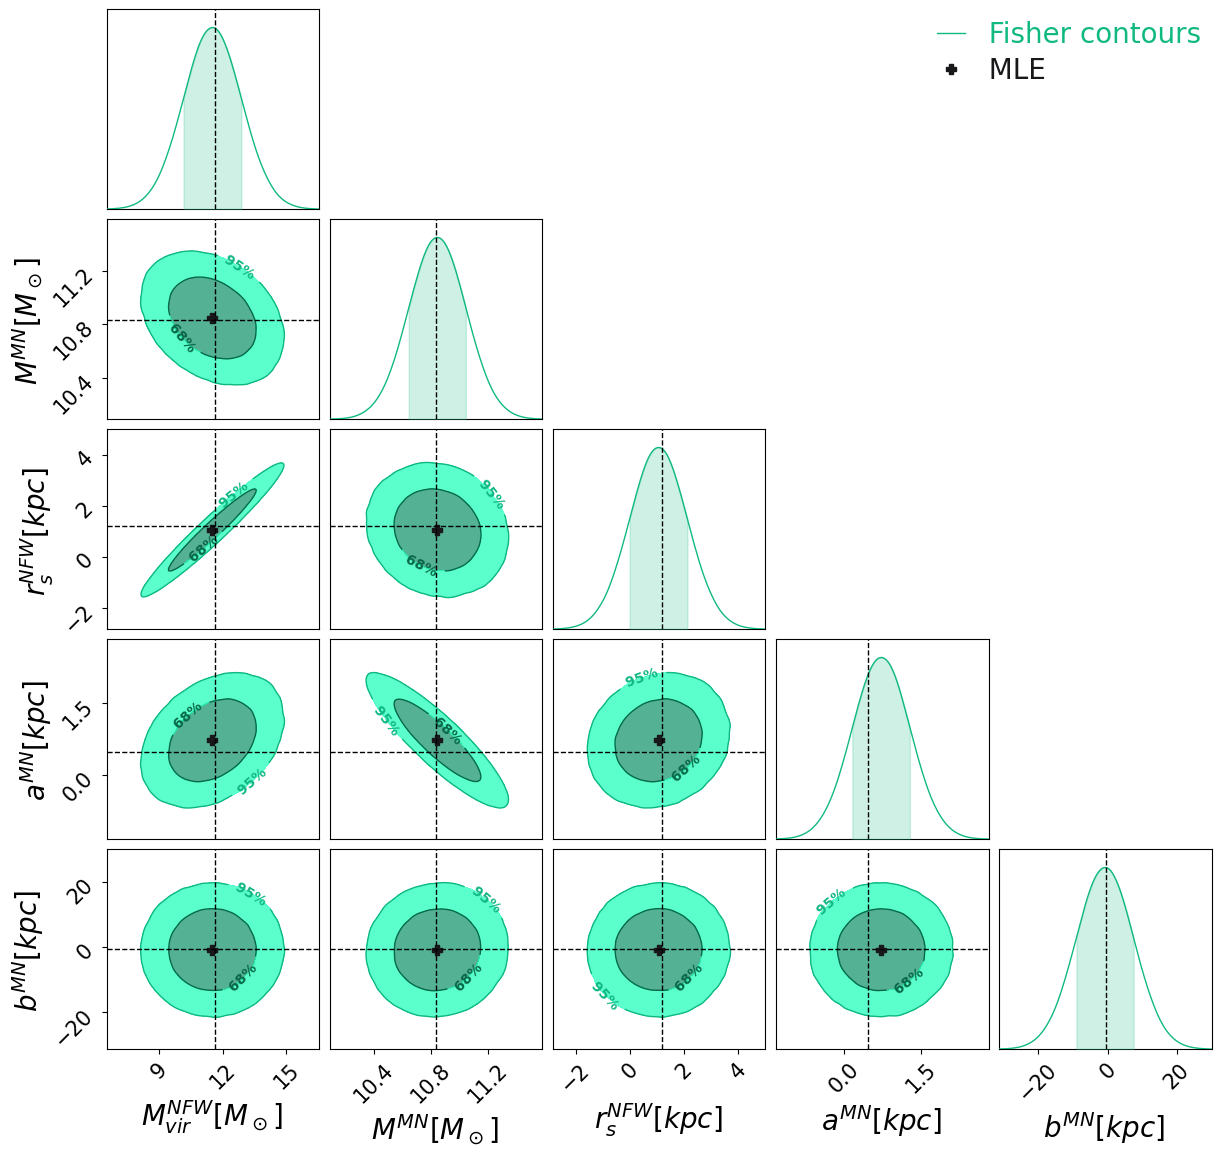

In [ ]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '2' 
from autocvd import autocvd
autocvd(num_gpus = 1)

import jax 
import jax.numpy as jnp
from jax import jit, random
import equinox as eqx
from jax.sharding import Mesh, PartitionSpec, NamedSharding

# jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt

from functools import partial

import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_LAXMAP, DIRECT_ACC_FOR_LOOP, DIRECT_ACC_MATRIX, NO_SELF_GRAVITY
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL, DIFFRAX_BACKEND, LEAPFROG
from odisseo.option_classes import SEMIIMPLICITEULER, TSIT5
from odisseo.option_classes import RECURSIVECHECKPOINTADJOING, FORWARDMODE
from odisseo.initial_condition import Plummer_sphere, Plummer_sphere_reparam
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot
from odisseo.potentials import MyamotoNagai, NFW

from odisseo.utils import halo_to_gd1_velocity_vmap, halo_to_gd1_vmap, projection_on_GD1
from jax.test_util import check_grads

plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

plt.style.use('default')


code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1, unit_time = code_time )  


config = SimulationConfig(N_particles = 1000, 
                          return_snapshots = True, 
                          num_snapshots = 1000, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.pc).to(code_units.code_length).value,
                          integrator = DIFFRAX_BACKEND,
                          differentation_mode=TSIT5,
                          fixed_timestep=False,
                          ) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.5 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 


key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)

#the center of mass needs to be integrated backwards in time first 
config_com = config._replace(N_particles=1,)
params_com = params._replace(t_end=-params.t_end,)

#this is the final position of the cluster, we need to integrate backwards in time 
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)


mass_com = jnp.array([params_com.Plummer_params.Mtot])
final_state_com = construct_initial_state(pos_com_final, vel_com_final)

snapshots_com = time_integration(final_state_com, mass_com, config_com, params_com)
pos_com, vel_com = snapshots_com.states[-1, :, 0], snapshots_com.states[-1, :, 1]


# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities)

#run the simulation
snapshots = time_integration(initial_state_stream, mass, config, params)

final_state = snapshots.states[-1]
stream_data = projection_on_GD1(final_state, code_units=code_units,)
print("Simulated GD1")


# LET'S TRY OPTIMIZING IT

params_sim = params
config_com = config_com._replace(diffrax_adjoint_method=FORWARDMODE,
)

@partial(jit, static_argnames=['return_residual'])
def run_simulation( y, return_residual=True):

    Mvir, M_MN, r_s, a, b, = y
    Mvir = 10**Mvir
    M_MN = 10**M_MN
    r_s = 10**r_s
    a = 10**a
    b = 10**b

    phi1_min, phi1_max = -100, 25
    phi2_min, phi2_max = -8, 2

    coord_indices = jnp.array([2, 3, 4, 5])


    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)

    #function that integrates the com backwards and forwards in time and then the stream, and projects it on the sky
    @jit
    def assign_params_integrate_projection(t_end):
        

        new_params = params_sim._replace(
                    NFW_params=params_sim.NFW_params._replace(
                        Mvir=Mvir * u.Msun.to(code_units.code_mass), 
                        r_s=r_s * u.kpc.to(code_units.code_length)
                    ),
                    MN_params=params_sim.MN_params._replace(
                        M=M_MN * u.Msun.to(code_units.code_mass),
                        a=a * u.kpc.to(code_units.code_length),
                        b=b * u.kpc.to(code_units.code_length),
                    ),
                     t_end = t_end,)
        snapshots = time_integration(initial_state_com, mass, config=config_com, params=new_params)
        stream_coordinate = jax.vmap(projection_on_GD1, in_axes=(0, None))(snapshots.states, code_units)
        return stream_coordinate

    t_end_mag = 0.5 * u.Gyr.to(code_units.code_time)
    t_end_array = jnp.array([-t_end_mag, t_end_mag])  # backward, forward
    

    # vmap over both parameters
    stream_coordinate_com = jax.vmap(assign_params_integrate_projection)(t_end_array)
    stream_coordinate_com_backward, stream_coordinate_com_forward = stream_coordinate_com[0], stream_coordinate_com[1]


    # Create masks for valid time steps
    mask_window_backward = (stream_coordinate_com_backward[:, 0, 1] < phi1_max) & \
                          (stream_coordinate_com_backward[:, 0, 1] > phi1_min) & \
                          (stream_coordinate_com_backward[:, 0, 2] < phi2_max) & \
                          (stream_coordinate_com_backward[:, 0, 2] > phi2_min)
    
    mask_diff_backward = jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1) > 0
    # New mask - True until first False appears
    mask_diff_backward = jnp.cumprod(mask_diff_backward, dtype=bool)


    mask_window_forward = (stream_coordinate_com_forward[:, 0, 1] < phi1_max) & \
                         (stream_coordinate_com_forward[:, 0, 1] > phi1_min) & \
                         (stream_coordinate_com_forward[:, 0, 2] < phi2_max) & \
                         (stream_coordinate_com_forward[:, 0, 2] > phi2_min)
    
    mask_diff_forward = jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=-1) < 0
    mask_diff_forward = jnp.cumprod(mask_diff_forward, dtype=bool)


    # Combined time step masks
    valid_time_backward = mask_window_backward & mask_diff_backward
    valid_time_forward = mask_window_forward & mask_diff_forward

    # Create masked coordinates for interpolation (only valid time steps)
    phi1_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, 1], 
                                   10000.)
    
    
    phi1_forward_valid = jnp.where(valid_time_forward, 
                                  stream_coordinate_com_forward[:, 0, 1], 
                                  -10000.)
    

    # Stream data masks - which data points to use for each direction
    mask_stream_backward = stream_data[:, 1] > stream_coordinate_com_backward[0, 0, 1]
    mask_stream_forward = stream_data[:, 1] < stream_coordinate_com_forward[0, 0, 1]

    mask_evaluate_inside_track_backward = (stream_data[:, 1] < jnp.max(phi1_backward_valid)) & (stream_data[:, 1] < phi1_max)
    mask_evaluate_inside_track_forward = (stream_data[:, 1] > jnp.min(phi1_forward_valid)) & (stream_data[:, 1] > phi1_min)

    def interpolate_coord_backward(coord_idx):

        coord_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, coord_idx], 
                                   -100000.0)

        return jnp.interp(
            jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward, stream_data[:, 1], 100000.0), 
            phi1_backward_valid, 
            coord_backward_valid
        )
    
    def interpolate_coord_forward(coord_idx):

        coord_forward_valid = jnp.where(valid_time_forward, 
                                   stream_coordinate_com_forward[:, 0, coord_idx], 
                                   100000.0)

        return jnp.interp(
            -jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward, stream_data[:, 1], -100000.0), 
            -phi1_forward_valid, 
            coord_forward_valid
        )
        

    # Apply interpolation to all coordinates
    interp_tracks_backward = jax.vmap(interpolate_coord_backward)(coord_indices)  # Shape: (n_coords, n_data)
    interp_tracks_forward = jax.vmap(interpolate_coord_forward)(coord_indices)  # Shape: (n_coords, n_data)

    # Calculate residuals for all coordinates
    data_coords = stream_data[:, coord_indices].T  # Shape: (n_coords, n_data)
    sigma = jnp.array([0.5, 10., 2., 2. ])
    # sigma = jnp.array([0.15, 5., 0.1, 0.0001]) #from albatross

    
    mask_correct_interpolation_backward = phi1_backward_valid < 20
    mask_correct_interpolation_forward = phi1_forward_valid > - 95

    # Calculate chi2 using only the appropriate data points for each direction
    residuals_backward = jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward, 
                                  (data_coords - interp_tracks_backward)/sigma[:, None],
                                   0.)
    residuals_forward = jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward, 
                                 (data_coords - interp_tracks_forward)/sigma[:, None],
                                  0.)
    
    # chi2_backward = jnp.sum(residuals_backward**2) 
    # chi2_forward = jnp.sum(residuals_forward**2) 
    
    # # Use only backward for now (as in your original code)
    # chi2 = chi2_backward + chi2_forward

    # if return_residual:
    #     return jnp.concatenate([residuals_backward**2, residuals_forward**2], axis=0).flatten()
    # else:
    #     return chi2
    # Count effective measurements
    # Each masked point contributes 4 coordinates (phi2, v_phi1, v_phi2, v_radial)
    
    # Masks for valid residuals
    mask_backward_full = mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward
    mask_forward_full = mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward
    
    n_eff_backward = jnp.nansum(mask_backward_full) * 4
    n_eff_forward = jnp.nansum(mask_forward_full) * 4
    n_total = n_eff_backward + n_eff_forward
    
    # Chi-squared
    chi2 = jnp.sum(residuals_backward**2) + jnp.sum(residuals_forward**2)
    
    # Reduced chi-squared (normalized by degrees of freedom)
    # n_params = 7  # or 4, depending on which version you're using
    # dof = jnp.maximum(n_total - n_params, 1.0)
    # reduced_chi2 = chi2 / dof
    
    if return_residual:
        # Return residuals divided by sqrt(dof) for proper scaling
        all_residuals = jnp.concatenate([residuals_backward, residuals_forward], axis=1).flatten()
        return all_residuals 
    else:
        return chi2

print("beginning least square optimization")

from optimistix import least_squares
import optimistix


# Shape will be (4, 4)
def sample_initial_conditions(key, n_samples, params, code_units):
    """
    Sample initial conditions from a uniform prior.
    
    Parameters are sampled uniformly in log-space between 0.5x and 2x the true values.
    
    Args:
        key: JAX random key
        n_samples: Number of samples to generate
        params: SimulationParams object with true parameter values
        code_units: CodeUnits object for unit conversions
    
    Returns:
        Array of shape (n_samples, 5) with log10 of [Mvir, M_MN, r_s, a, b]
    """
    # Get true values in physical units
    true_Mvir = params.NFW_params.Mvir * code_units.code_mass.to(u.Msun)
    true_M_MN = params.MN_params.M * code_units.code_mass.to(u.Msun)
    true_r_s = params.NFW_params.r_s * code_units.code_length.to(u.kpc)
    true_a = params.MN_params.a * code_units.code_length.to(u.kpc)
    true_b = params.MN_params.b * code_units.code_length.to(u.kpc)
    
    # Define bounds: [0.5 * true_value, 2.0 * true_value]
    min_factor = 0.5
    max_factor = 2.0
    
    # Stack true values
    true_values = jnp.array([true_Mvir, true_M_MN, true_r_s, true_a, true_b])
    
    # Calculate min and max in log space
    log_min = jnp.log10(true_values * min_factor)
    log_max = jnp.log10(true_values * max_factor)
    
    # min_vals = true_values * min_factor
    # max_vals = true_values * max_factor
    # Sample uniformly in log space
    keys = random.split(key, 5)
    samples = []
    
    for i in range(5):
        param_samples = random.uniform(
            keys[i], 
            shape=(n_samples,), 
            minval=log_min[i], 
            maxval=log_max[i]
        )
        samples.append(param_samples)
    
    # Stack into (n_samples, 5) array
    y0_batched = jnp.stack(samples, axis=1)
    
    return y0_batched


# Example usage:
key = random.PRNGKey(0)
n_samples = 20
y0_batched = sample_initial_conditions(key, n_samples, params, code_units)


# Shape will be (4, 4)
def minimization_vmap(y0):
    return least_squares(
        fn=run_simulation,
        solver=optimistix.LevenbergMarquardt(rtol=1e-5, atol=1e-5),
        y0=y0,
    ).value

values = jax.vmap(minimization_vmap)(y0_batched)

likelihood = jax.vmap(lambda v: run_simulation(v, return_residual=False))(values)
MLE_index = jnp.argmin(likelihood)


#remember to put FORWARD MODE for the adjoint method when calculating the hessian
config_com = config_com._replace(diffrax_adjoint_method=FORWARDMODE,)
# hessians = jax.vmap(lambda v: jax.jacfwd(jax.jacfwd(run_simulation))(v, False))(values)
hessians = jax.jacfwd(jax.jacfwd(run_simulation))(values[MLE_index], False)

#The Fisher information matrix is the negative of the Hessian of the log-likelihood
fisher_info = - hessians

#The covariance matrix is the inverse of the Fisher information matrix
covariance = jnp.linalg.inv(fisher_info)


from chainconsumer import Chain, ChainConsumer, Truth, PlotConfig

colors = ['red', 'blue', 'green', 'purple']
c = ChainConsumer()
chain = Chain.from_covariance(mean=values[MLE_index], 
                                covariance=covariance, 
                                columns=["$M_{vir}^{NFW} [M_\odot]$", "$M^{MN} [M_\odot]$", "$r_s^{NFW} [kpc]$", "$a^{MN} [kpc]$", "$b^{MN} [kpc]$"], 
                                color="emerald",  
                                name=f'Fisher contours',
                                show_contour_labels=True,
                                shade_alpha=0.7
)

c.add_chain(chain)
c.add_marker(location = {"$M_{vir}^{NFW} [M_\odot]$": np.array(values[MLE_index][0]), "$M^{MN} [M_\odot]$": np.array(values[MLE_index][1]),
                            "$r_s^{NFW} [kpc]$": np.array(values[MLE_index][2]), "$a^{MN} [kpc]$": np.array(values[MLE_index][3]), "$b^{MN} [kpc]$": np.array(values[MLE_index][4]),
                            }, color="black", name='MLE', marker_style='P', marker_size=50)

c.add_truth(Truth(location = {"$M_{vir}^{NFW} [M_\odot]$": jnp.log10(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun)), 
                            "$M^{MN} [M_\odot]$": jnp.log10(params.MN_params.M * code_units.code_mass.to(u.Msun)),
                            "$r_s^{NFW} [kpc]$": jnp.log10(params.NFW_params.r_s * code_units.code_length.to(u.kpc)),
                            "$a^{MN} [kpc]$": jnp.log10(params.MN_params.a * code_units.code_length.to(u.kpc)),
                            "$b^{MN} [kpc]$": jnp.log10(params.MN_params.b * code_units.code_length.to(u.kpc)),
                            }, 
                            color='black', name="True value"))


c.set_plot_config(
PlotConfig(
    max_ticks=4,
    label_font_size=20,
    tick_font_size=15,
    summary_font_size=20,

))
fig = c.plotter.plot()
fig.savefig("Fisher_contour_least_square_AllParameters_final.png", dpi=300)

In [2]:
fig.savefig("Fisher_contour_least_square_AllParameters_final.png", dpi=300)

The history saving thread hit an unexpected error (DatabaseError('database disk image is malformed')).History will not be written to the database.
Simulated GD1
beginning least square optimization


/export/home/vgiusepp/miniconda3/envs/odisseo_sim/lib/python3.12/site-packages/chainconsumer/chain.py:313: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = rng.multivariate_normal(mean, covariance, size=1000000)  # type: ignore


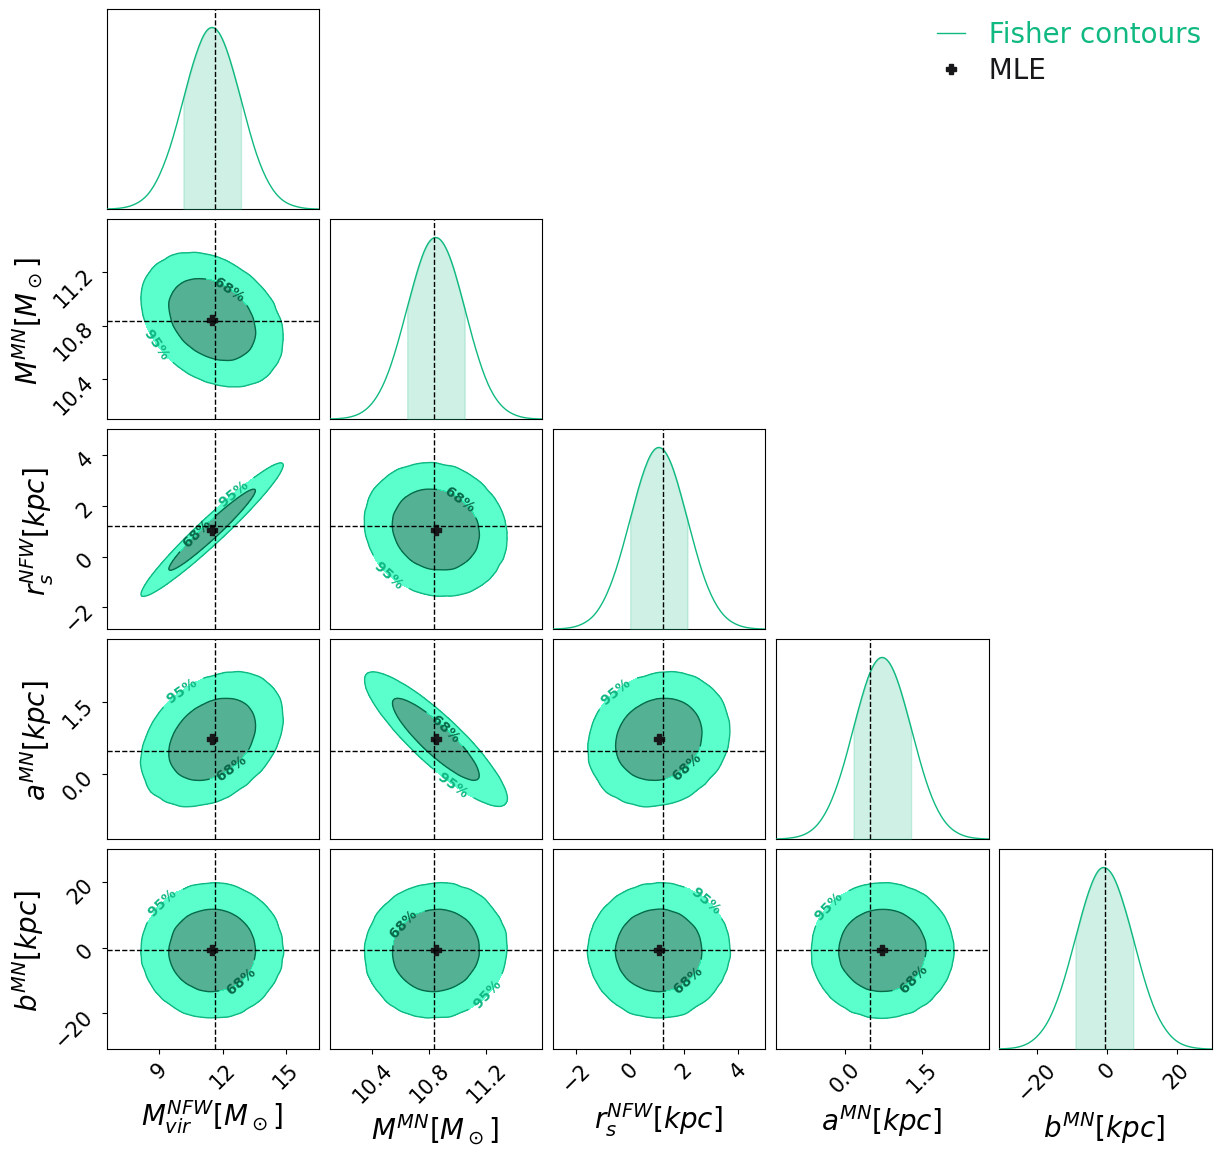

In [1]:
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '2' 
from autocvd import autocvd
autocvd(num_gpus = 1)

import jax 
import jax.numpy as jnp
from jax import jit, random
import equinox as eqx
from jax.sharding import Mesh, PartitionSpec, NamedSharding

# jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt

from functools import partial

import numpy as np
from astropy import units as u
from astropy import constants as c

import odisseo
from odisseo import construct_initial_state
from odisseo.integrators import leapfrog
from odisseo.dynamics import direct_acc, DIRECT_ACC, DIRECT_ACC_LAXMAP, DIRECT_ACC_FOR_LOOP, DIRECT_ACC_MATRIX, NO_SELF_GRAVITY
from odisseo.option_classes import SimulationConfig, SimulationParams, MNParams, NFWParams, PlummerParams, PSPParams, MN_POTENTIAL, NFW_POTENTIAL, PSP_POTENTIAL, DIFFRAX_BACKEND, LEAPFROG
from odisseo.option_classes import SEMIIMPLICITEULER, TSIT5
from odisseo.option_classes import RECURSIVECHECKPOINTADJOING, FORWARDMODE
from odisseo.initial_condition import Plummer_sphere, Plummer_sphere_reparam
from odisseo.utils import center_of_mass
from odisseo.time_integration import time_integration
from odisseo.units import CodeUnits
from odisseo.visualization import create_3d_gif, create_projection_gif, energy_angular_momentum_plot
from odisseo.potentials import MyamotoNagai, NFW

from odisseo.utils import halo_to_gd1_velocity_vmap, halo_to_gd1_vmap, projection_on_GD1
from jax.test_util import check_grads

plt.rcParams.update({
    'font.size': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'legend.fontsize': 15,
})

plt.style.use('default')


code_length = 10 * u.kpc
code_mass = 1e4 * u.Msun
G = 1
code_time = 3 * u.Gyr
code_units = CodeUnits(code_length, code_mass, G=1, unit_time = code_time )  


config = SimulationConfig(N_particles = 1000, 
                          return_snapshots = True, 
                          num_snapshots = 1000, 
                          num_timesteps = 1000, 
                          external_accelerations=(NFW_POTENTIAL, MN_POTENTIAL, PSP_POTENTIAL), 
                          acceleration_scheme = DIRECT_ACC_MATRIX,
                          softening = (0.1 * u.pc).to(code_units.code_length).value,
                          integrator = DIFFRAX_BACKEND,
                          differentation_mode=TSIT5,
                          fixed_timestep=False,
                          ) #default values

params = SimulationParams(t_end = (3 * u.Gyr).to(code_units.code_time).value,  
                          Plummer_params= PlummerParams(Mtot=(10**4.5 * u.Msun).to(code_units.code_mass).value,
                                                        a=(8 * u.pc).to(code_units.code_length).value),
                           MN_params= MNParams(M = (68_193_902_782.346756 * u.Msun).to(code_units.code_mass).value,
                                              a = (3.0 * u.kpc).to(code_units.code_length).value,
                                              b = (0.280 * u.kpc).to(code_units.code_length).value),
                          NFW_params= NFWParams(Mvir=(4.3683325e11 * u.Msun).to(code_units.code_mass).value,
                                               r_s= (16.0 * u.kpc).to(code_units.code_length).value,),      
                          PSP_params= PSPParams(M = 4501365375.06545 * u.Msun.to(code_units.code_mass),
                                                alpha = 1.8, 
                                                r_c = (1.9*u.kpc).to(code_units.code_length).value),                    
                          G=code_units.G, ) 


key = random.PRNGKey(1)

#set up the particles in the initial state
positions, velocities, mass = Plummer_sphere(key=key, params=params, config=config)

#the center of mass needs to be integrated backwards in time first 
config_com = config._replace(N_particles=1,)
params_com = params._replace(t_end=-params.t_end,)

#this is the final position of the cluster, we need to integrate backwards in time 
pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)


mass_com = jnp.array([params_com.Plummer_params.Mtot])
final_state_com = construct_initial_state(pos_com_final, vel_com_final)

snapshots_com = time_integration(final_state_com, mass_com, config_com, params_com)
pos_com, vel_com = snapshots_com.states[-1, :, 0], snapshots_com.states[-1, :, 1]


# Add the center of mass position and velocity to the Plummer sphere particles
positions = positions + pos_com
velocities = velocities + vel_com

#initialize the initial state
initial_state_stream = construct_initial_state(positions, velocities)

#run the simulation
snapshots = time_integration(initial_state_stream, mass, config, params)

final_state = snapshots.states[-1]
stream_data = projection_on_GD1(final_state, code_units=code_units,)
print("Simulated GD1")


# LET'S TRY OPTIMIZING IT

params_sim = params
config_com = config_com._replace(diffrax_adjoint_method=FORWARDMODE,
)

@partial(jit, static_argnames=['return_residual'])
def run_simulation( y, return_residual=True):

    Mvir, M_MN, r_s, a, b, = y
    Mvir = 10**Mvir
    M_MN = 10**M_MN
    r_s = 10**r_s
    a = 10**a
    b = 10**b

    phi1_min, phi1_max = -100, 25
    phi2_min, phi2_max = -8, 2

    coord_indices = jnp.array([2, 3, 4, 5])


    #Final position and velocity of the center of mass
    pos_com_final = jnp.array([[11.8, 0.79, 6.4]]) * u.kpc.to(code_units.code_length)
    vel_com_final = jnp.array([[109.5,-254.5,-90.3]]) * (u.km/u.s).to(code_units.code_velocity)
    
    #we construmt the initial state of the com 
    initial_state_com = construct_initial_state(pos_com_final, vel_com_final,)

    #function that integrates the com backwards and forwards in time and then the stream, and projects it on the sky
    @jit
    def assign_params_integrate_projection(t_end):
        

        new_params = params_sim._replace(
                    NFW_params=params_sim.NFW_params._replace(
                        Mvir=Mvir * u.Msun.to(code_units.code_mass), 
                        r_s=r_s * u.kpc.to(code_units.code_length)
                    ),
                    MN_params=params_sim.MN_params._replace(
                        M=M_MN * u.Msun.to(code_units.code_mass),
                        a=a * u.kpc.to(code_units.code_length),
                        b=b * u.kpc.to(code_units.code_length),
                    ),
                     t_end = t_end,)
        snapshots = time_integration(initial_state_com, mass, config=config_com, params=new_params)
        stream_coordinate = jax.vmap(projection_on_GD1, in_axes=(0, None))(snapshots.states, code_units)
        return stream_coordinate

    t_end_mag = 0.5 * u.Gyr.to(code_units.code_time)
    t_end_array = jnp.array([-t_end_mag, t_end_mag])  # backward, forward
    

    # vmap over both parameters
    stream_coordinate_com = jax.vmap(assign_params_integrate_projection)(t_end_array)
    stream_coordinate_com_backward, stream_coordinate_com_forward = stream_coordinate_com[0], stream_coordinate_com[1]


    # Create masks for valid time steps
    mask_window_backward = (stream_coordinate_com_backward[:, 0, 1] < phi1_max) & \
                          (stream_coordinate_com_backward[:, 0, 1] > phi1_min) & \
                          (stream_coordinate_com_backward[:, 0, 2] < phi2_max) & \
                          (stream_coordinate_com_backward[:, 0, 2] > phi2_min)
    
    mask_diff_backward = jnp.ediff1d(stream_coordinate_com_backward[:, 0, 1], to_begin=1) > 0
    # New mask - True until first False appears
    mask_diff_backward = jnp.cumprod(mask_diff_backward, dtype=bool)


    mask_window_forward = (stream_coordinate_com_forward[:, 0, 1] < phi1_max) & \
                         (stream_coordinate_com_forward[:, 0, 1] > phi1_min) & \
                         (stream_coordinate_com_forward[:, 0, 2] < phi2_max) & \
                         (stream_coordinate_com_forward[:, 0, 2] > phi2_min)
    
    mask_diff_forward = jnp.ediff1d(stream_coordinate_com_forward[:, 0, 1], to_begin=-1) < 0
    mask_diff_forward = jnp.cumprod(mask_diff_forward, dtype=bool)


    # Combined time step masks
    valid_time_backward = mask_window_backward & mask_diff_backward
    valid_time_forward = mask_window_forward & mask_diff_forward

    # Create masked coordinates for interpolation (only valid time steps)
    phi1_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, 1], 
                                   10000.)
    
    
    phi1_forward_valid = jnp.where(valid_time_forward, 
                                  stream_coordinate_com_forward[:, 0, 1], 
                                  -10000.)
    

    # Stream data masks - which data points to use for each direction
    mask_stream_backward = stream_data[:, 1] > stream_coordinate_com_backward[0, 0, 1]
    mask_stream_forward = stream_data[:, 1] < stream_coordinate_com_forward[0, 0, 1]

    mask_evaluate_inside_track_backward = (stream_data[:, 1] < jnp.max(phi1_backward_valid)) & (stream_data[:, 1] < phi1_max)
    mask_evaluate_inside_track_forward = (stream_data[:, 1] > jnp.min(phi1_forward_valid)) & (stream_data[:, 1] > phi1_min)

    def interpolate_coord_backward(coord_idx):

        coord_backward_valid = jnp.where(valid_time_backward, 
                                   stream_coordinate_com_backward[:, 0, coord_idx], 
                                   -100000.0)

        return jnp.interp(
            jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward, stream_data[:, 1], 100000.0), 
            phi1_backward_valid, 
            coord_backward_valid
        )
    
    def interpolate_coord_forward(coord_idx):

        coord_forward_valid = jnp.where(valid_time_forward, 
                                   stream_coordinate_com_forward[:, 0, coord_idx], 
                                   100000.0)

        return jnp.interp(
            -jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward, stream_data[:, 1], -100000.0), 
            -phi1_forward_valid, 
            coord_forward_valid
        )
        

    # Apply interpolation to all coordinates
    interp_tracks_backward = jax.vmap(interpolate_coord_backward)(coord_indices)  # Shape: (n_coords, n_data)
    interp_tracks_forward = jax.vmap(interpolate_coord_forward)(coord_indices)  # Shape: (n_coords, n_data)

    # Calculate residuals for all coordinates
    data_coords = stream_data[:, coord_indices].T  # Shape: (n_coords, n_data)
    sigma = jnp.array([0.5, 10., 2., 2. ])
    # sigma = jnp.array([0.15, 5., 0.1, 0.0001]) #from albatross

    
    mask_correct_interpolation_backward = phi1_backward_valid < 20
    mask_correct_interpolation_forward = phi1_forward_valid > - 95

    # Calculate chi2 using only the appropriate data points for each direction
    residuals_backward = jnp.where(mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward, 
                                  (data_coords - interp_tracks_backward)/sigma[:, None],
                                   0.)
    residuals_forward = jnp.where(mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward, 
                                 (data_coords - interp_tracks_forward)/sigma[:, None],
                                  0.)
    
    # chi2_backward = jnp.sum(residuals_backward**2) 
    # chi2_forward = jnp.sum(residuals_forward**2) 
    
    # # Use only backward for now (as in your original code)
    # chi2 = chi2_backward + chi2_forward

    # if return_residual:
    #     return jnp.concatenate([residuals_backward**2, residuals_forward**2], axis=0).flatten()
    # else:
    #     return chi2
    # Count effective measurements
    # Each masked point contributes 4 coordinates (phi2, v_phi1, v_phi2, v_radial)
    
    # Masks for valid residuals
    mask_backward_full = mask_stream_backward & mask_evaluate_inside_track_backward & mask_correct_interpolation_backward
    mask_forward_full = mask_stream_forward & mask_evaluate_inside_track_forward & mask_correct_interpolation_forward
    
    n_eff_backward = jnp.nansum(mask_backward_full) * 4
    n_eff_forward = jnp.nansum(mask_forward_full) * 4
    n_total = n_eff_backward + n_eff_forward
    
    # Chi-squared
    chi2 = jnp.sum(residuals_backward**2) + jnp.sum(residuals_forward**2)
    
    # Reduced chi-squared (normalized by degrees of freedom)
    # n_params = 7  # or 4, depending on which version you're using
    # dof = jnp.maximum(n_total - n_params, 1.0)
    # reduced_chi2 = chi2 / dof
    
    if return_residual:
        # Return residuals divided by sqrt(dof) for proper scaling
        all_residuals = jnp.concatenate([residuals_backward, residuals_forward], axis=1).flatten()
        return all_residuals 
    else:
        return chi2

print("beginning least square optimization")

from optimistix import least_squares
import optimistix


# Shape will be (4, 4)
def sample_initial_conditions(key, n_samples, params, code_units):
    """
    Sample initial conditions from a uniform prior.
    
    Parameters are sampled uniformly in log-space between 0.5x and 2x the true values.
    
    Args:
        key: JAX random key
        n_samples: Number of samples to generate
        params: SimulationParams object with true parameter values
        code_units: CodeUnits object for unit conversions
    
    Returns:
        Array of shape (n_samples, 5) with log10 of [Mvir, M_MN, r_s, a, b]
    """
    # Get true values in physical units
    true_Mvir = params.NFW_params.Mvir * code_units.code_mass.to(u.Msun)
    true_M_MN = params.MN_params.M * code_units.code_mass.to(u.Msun)
    true_r_s = params.NFW_params.r_s * code_units.code_length.to(u.kpc)
    true_a = params.MN_params.a * code_units.code_length.to(u.kpc)
    true_b = params.MN_params.b * code_units.code_length.to(u.kpc)
    
    # Define bounds: [0.5 * true_value, 2.0 * true_value]
    min_factor = 0.5
    max_factor = 2.0
    
    # Stack true values
    true_values = jnp.array([true_Mvir, true_M_MN, true_r_s, true_a, true_b])
    
    # Calculate min and max in log space
    log_min = jnp.log10(true_values * min_factor)
    log_max = jnp.log10(true_values * max_factor)
    
    # min_vals = true_values * min_factor
    # max_vals = true_values * max_factor
    # Sample uniformly in log space
    keys = random.split(key, 5)
    samples = []
    
    for i in range(5):
        param_samples = random.uniform(
            keys[i], 
            shape=(n_samples,), 
            minval=log_min[i], 
            maxval=log_max[i]
        )
        samples.append(param_samples)
    
    # Stack into (n_samples, 5) array
    y0_batched = jnp.stack(samples, axis=1)
    
    return y0_batched


# Example usage:
key = random.PRNGKey(0)
n_samples = 100
y0_batched = sample_initial_conditions(key, n_samples, params, code_units)


# Shape will be (4, 4)
def minimization_vmap(y0):
    return least_squares(
        fn=run_simulation,
        solver=optimistix.LevenbergMarquardt(rtol=1e-5, atol=1e-5),
        y0=y0,
    ).value

values = jax.vmap(minimization_vmap)(y0_batched)

likelihood = jax.vmap(lambda v: run_simulation(v, return_residual=False))(values)
MLE_index = jnp.argmin(likelihood)


#remember to put FORWARD MODE for the adjoint method when calculating the hessian
config_com = config_com._replace(diffrax_adjoint_method=FORWARDMODE,)
# hessians = jax.vmap(lambda v: jax.jacfwd(jax.jacfwd(run_simulation))(v, False))(values)
hessians = jax.jacfwd(jax.jacfwd(run_simulation))(values[MLE_index], False)

#The Fisher information matrix is the negative of the Hessian of the log-likelihood
fisher_info = - hessians

#The covariance matrix is the inverse of the Fisher information matrix
covariance = jnp.linalg.inv(fisher_info)


from chainconsumer import Chain, ChainConsumer, Truth, PlotConfig

colors = ['red', 'blue', 'green', 'purple']
c = ChainConsumer()
chain = Chain.from_covariance(mean=values[MLE_index], 
                                covariance=covariance, 
                                columns=["$M_{vir}^{NFW} [M_\odot]$", "$M^{MN} [M_\odot]$", "$r_s^{NFW} [kpc]$", "$a^{MN} [kpc]$", "$b^{MN} [kpc]$"], 
                                color="emerald",  
                                name=f'Fisher contours',
                                show_contour_labels=True,
                                shade_alpha=0.7
)

c.add_chain(chain)
c.add_marker(location = {"$M_{vir}^{NFW} [M_\odot]$": np.array(values[MLE_index][0]), "$M^{MN} [M_\odot]$": np.array(values[MLE_index][1]),
                            "$r_s^{NFW} [kpc]$": np.array(values[MLE_index][2]), "$a^{MN} [kpc]$": np.array(values[MLE_index][3]), "$b^{MN} [kpc]$": np.array(values[MLE_index][4]),
                            }, color="black", name='MLE', marker_style='P', marker_size=50)

c.add_truth(Truth(location = {"$M_{vir}^{NFW} [M_\odot]$": jnp.log10(params.NFW_params.Mvir * code_units.code_mass.to(u.Msun)), 
                            "$M^{MN} [M_\odot]$": jnp.log10(params.MN_params.M * code_units.code_mass.to(u.Msun)),
                            "$r_s^{NFW} [kpc]$": jnp.log10(params.NFW_params.r_s * code_units.code_length.to(u.kpc)),
                            "$a^{MN} [kpc]$": jnp.log10(params.MN_params.a * code_units.code_length.to(u.kpc)),
                            "$b^{MN} [kpc]$": jnp.log10(params.MN_params.b * code_units.code_length.to(u.kpc)),
                            }, 
                            color='black', name="True value"))


c.set_plot_config(
PlotConfig(
    max_ticks=4,
    label_font_size=20,
    tick_font_size=15,
    summary_font_size=20,

))
fig = c.plotter.plot()

/export/home/vgiusepp/miniconda3/envs/sbi_sim/lib/python3.12/site-packages/chainconsumer/chain.py:313: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  samples = rng.multivariate_normal(mean, covariance, size=1000000)  # type: ignore


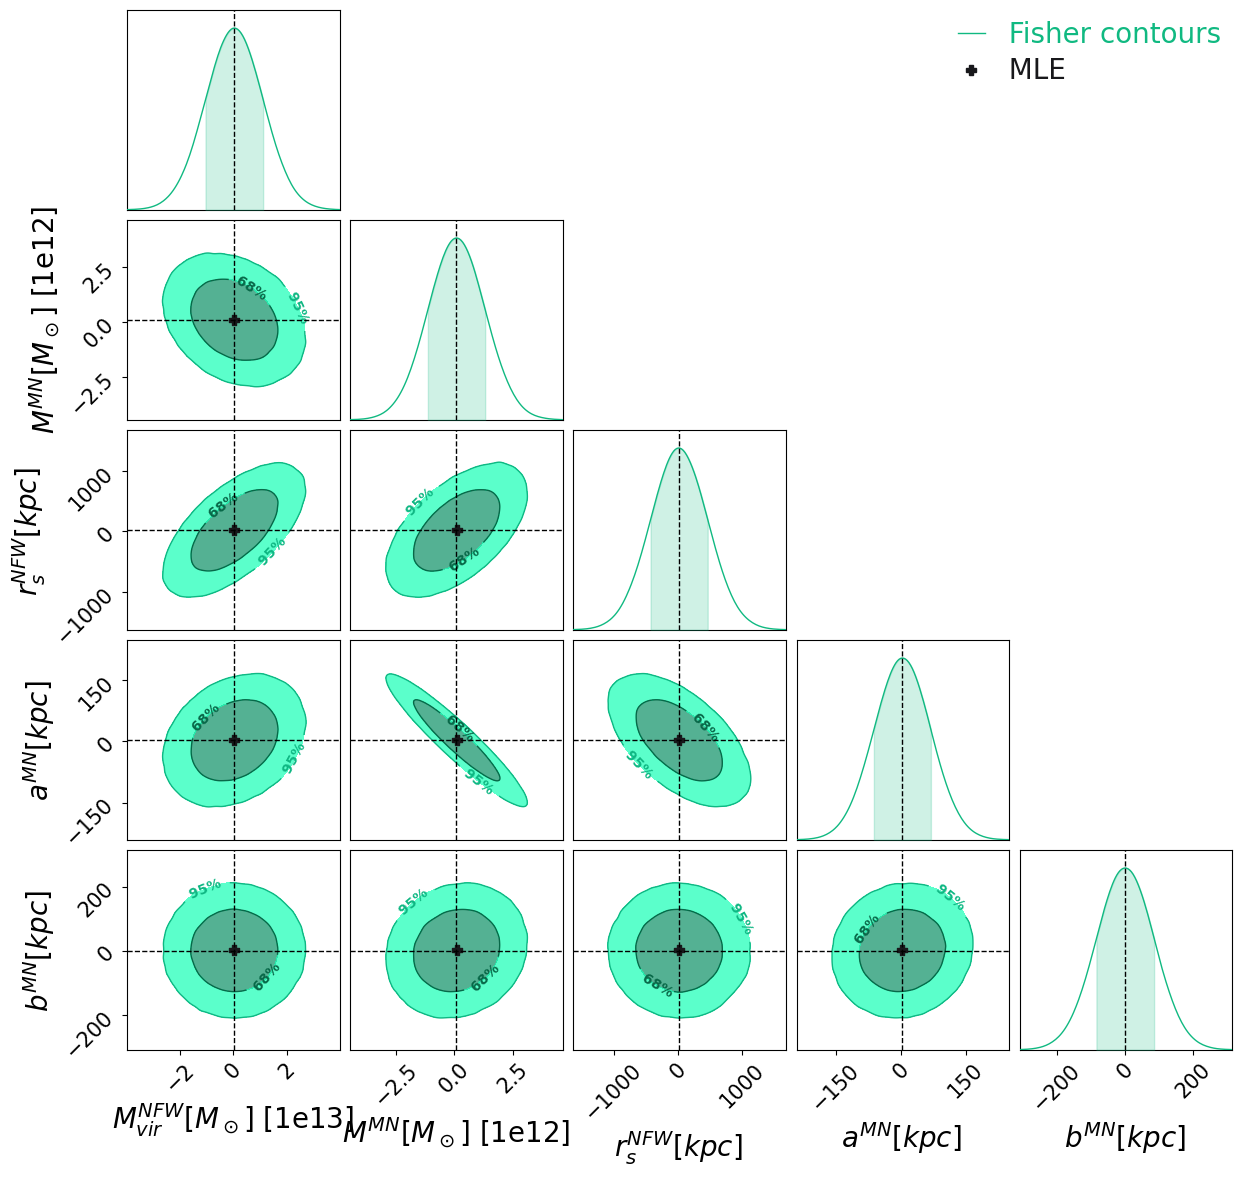

In [ ]:
from chainconsumer import Chain, ChainConsumer, Truth, PlotConfig

colors = ['red', 'blue', 'green', 'purple']
c = ChainConsumer()
chain = Chain.from_covariance(mean=values[MLE_index], 
                                covariance=covariance, 
                                columns=["$M_{vir}^{NFW} [M_\odot]$", "$M^{MN} [M_\odot]$", "$r_s^{NFW} [kpc]$", "$a^{MN} [kpc]$", "$b^{MN} [kpc]$"], 
                                color="emerald",  
                                name=f'Fisher contours',
                                show_contour_labels=True,
                                shade_alpha=0.7
)

c.add_chain(chain)
c.add_marker(location = {"$M_{vir}^{NFW} [M_\odot]$": np.array(values[MLE_index][0]), "$M^{MN} [M_\odot]$": np.array(values[MLE_index][1]),
                            "$r_s^{NFW} [kpc]$": np.array(values[MLE_index][2]), "$a^{MN} [kpc]$": np.array(values[MLE_index][3]), "$b^{MN} [kpc]$": np.array(values[MLE_index][4]),
                            }, color="black", name='MLE', marker_style='P', marker_size=50)

c.add_truth(Truth(location = {"$M_{vir}^{NFW} [M_\odot]$": params.NFW_params.Mvir * code_units.code_mass.to(u.Msun), 
                            "$M^{MN} [M_\odot]$": params.MN_params.M * code_units.code_mass.to(u.Msun),
                            "$r_s^{NFW} [kpc]$": params.NFW_params.r_s * code_units.code_length.to(u.kpc),
                            "$a^{MN} [kpc]$": params.MN_params.a * code_units.code_length.to(u.kpc),
                            "$b^{MN} [kpc]$": params.MN_params.b * code_units.code_length.to(u.kpc),
                            }, 
                            color='black', name="True value"))


c.set_plot_config(
PlotConfig(
    max_ticks=4,
    label_font_size=20,
    tick_font_size=15,
    summary_font_size=20,

))
fig = c.plotter.plot()